# NN HW 2 - Simple RNN training - Andrei Gabriel Popescu
### Adapted from the EEML2019 Tutorial on RNNs

The objective is to analyze the training of various RNNs on simple datasets and doing some analysis.  

## Imports

In [1]:
#@title Imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import numpy as np
import seaborn as sns

import torch
import torch.nn as nn 


from matplotlib import pyplot as plt
  
sns.set_style('ticks')  

# Fix a seed for the entire experiment to ensure reproducible results.
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)

C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Vanilla RNN

Implement basic RNN cell using tf.layers.

   $$ h_t = f( Wx_t + Vh_{t-1}  + b) $$
   
   Where
   
   * $x_t$ input at time $t$
   * $h_t$ hidden state at time $t$
   * $W$ input-to-hidden mapping (trainable)
   * $V$ hidden-to-hidden mapping (trainable)
   * $b$ bias (trainable)
   * $f$ non-linearity chosen (usually tanh)

### Implement Vanilla RNN Base recurrence model
$h_t = f(input + V h_{(t-1)} + b)$

In [2]:
class VanillaRNNBase(nn.Module):
  
    def __init__(self, hidden_size, activation=nn.Tanh, bias=True):    
        """
        Constructor for a simple RNNCell where the hidden-to-hidden transitions
        are defined by a linear layer and the default activation of `tanh` 
        :param hidden_size: the size of the hidden state
        :param activation: the activation function used for computing the next hidden state
        """
        super(VanillaRNNBase, self).__init__()
    
        self._hidden_size = hidden_size
        self._activation = activation()  
        self._bias = bias
            
        # TODO 1.1 Create the hidden-to-hidden layer
        self._linear_hh = nn.Linear(self._hidden_size, self._hidden_size, bias=self._bias)


    def forward(self, inputs, hidden=None):
        out = inputs
        #### TODO 1.1 Your code here
        ### ...
        #### end code
        out = self._linear_hh(out)
        out = self._activation(out)
        
        return out, out


class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=20, bias=False):
        """
        Creates a vanilla RNN where input-to-hidden is a nn.Linear layer
        and hidden-to-output is a nn.Linear layer
        
        :param input_size: the size of the input to the RNN
        :param hidden_size: size of the hidden state of the RNN
        :param output_size: size of the output
        """
        super(VanillaRNN, self).__init__()
        
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        self._bias = bias
        
        self.in_to_hidden = nn.Linear(self._input_size, self._hidden_size, bias=self._bias)
        self.rnn_cell = VanillaRNNBase(self._hidden_size, bias=self._bias)
        self.hidden_to_out = nn.Linear(self._hidden_size, self._output_size, bias=self._bias)
    
    def step(self, input, hidden=None):
        ### TODO 1.2 compute one step in the RNN
        input_ = self.in_to_hidden(input)
        _, hidden_ =  self.rnn_cell(input_, hidden=hidden)
        output_ = self.hidden_to_out(hidden_)
        
        return output_, hidden_
    
    def forward(self, inputs, hidden=None, force=True, warm_start=10):
        steps = len(inputs)
        
        # Create a trainable set of states for cells
        outputs = torch.autograd.Variable(torch.zeros(steps, self._output_size, self._output_size))
        
        output_ = None
        hidden_ = hidden
        
        for i in range(steps):
            ## TODO 1.3 Implement forward pass in RNN
            ## Implement Teacher Forcing and Warm Start
            input_ = None
            if force:
                input_ = inputs[i]
            else:
                # Generative scenrio
                if i <= warm_start:
                    input_ = inputs[i]
                else:
                    input_ = output_ # former prediction
            
            ### END Code
            
            output_, hidden_ = self.step(input_, hidden_)
            outputs[i] = output_
            
        return outputs, hidden_
        

## Train RNN on sine wave

Train the RNN on sine data - predict the next sine value from *predicted* sine values.

Predict   $$ sin (x +t \epsilon) $$ from $$ sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) $$

In particular, we want the network to predict the next value in a loop, conditioning the prediction on some initial values (provided) and all subsequent predictions.

To learn the prediction model, we will use *teacher forcing*. This means that when training the model, the input at time $t$ is the real sequence at time $t$, rather than the output produced by the model at $t-1$.

When we want to generate data from the model, we do not have access to the true sequence, so we do not use teacher forcing. However, in the case of our problem, we will also use *warm starting*, because we require multiple time steps to predict the next sine wave value (at least 2, for the initial value and for the step). 

The code below unrolls the RNN core you have defined above, does the training using backprop though time and plots the real data ("ground truth"), the data generated during training ("train predictions") and the model samples "generated".


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

Running code @ cpu


[200] avg_loss: 0.48104, report_loss: 0.47847, 


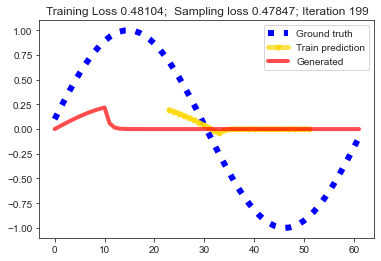

[400] avg_loss: 0.83106, report_loss: 0.40248, 


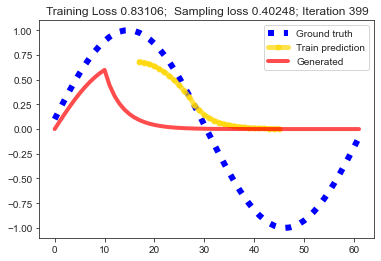

[600] avg_loss: 1.05418, report_loss: 0.37618, 


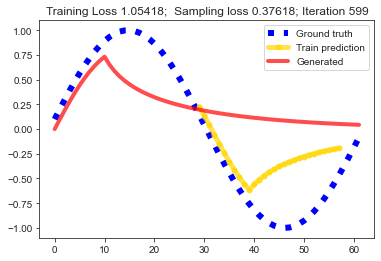

[800] avg_loss: 1.28442, report_loss: 0.35389, 


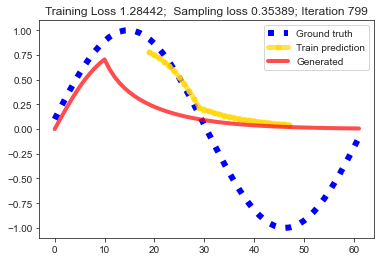

[1000] avg_loss: 1.50775, report_loss: 0.37162, 


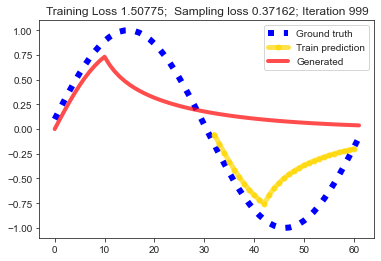

[1200] avg_loss: 1.72192, report_loss: 0.35691, 


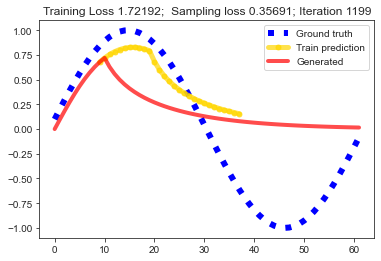

[1400] avg_loss: 1.94288, report_loss: 0.38610, 


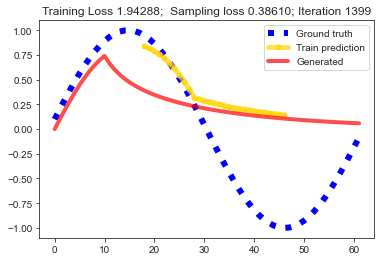

[1600] avg_loss: 2.15489, report_loss: 0.38092, 


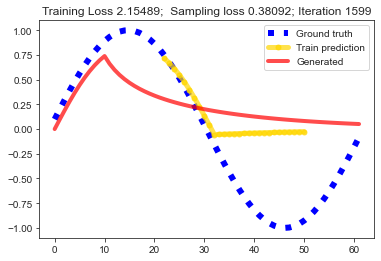

[1800] avg_loss: 2.37354, report_loss: 0.35894, 


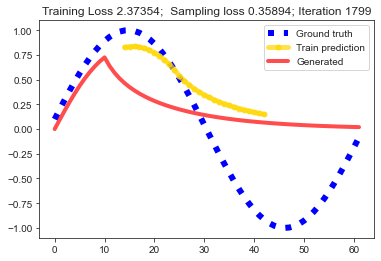

[2000] avg_loss: 2.59259, report_loss: 0.36511, 


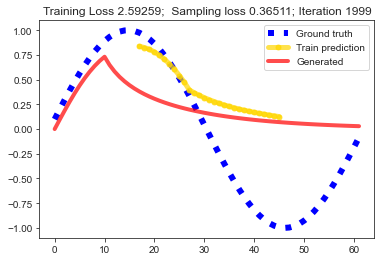

[2200] avg_loss: 2.81665, report_loss: 0.41741, 


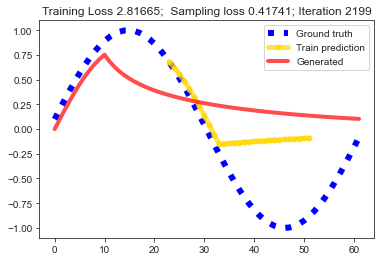

[2400] avg_loss: 3.03408, report_loss: 0.41428, 


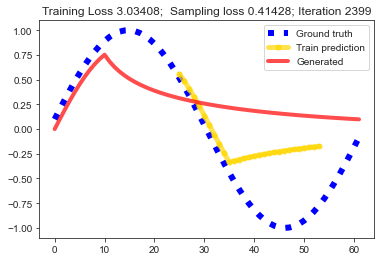

[2600] avg_loss: 3.25709, report_loss: 0.38241, 


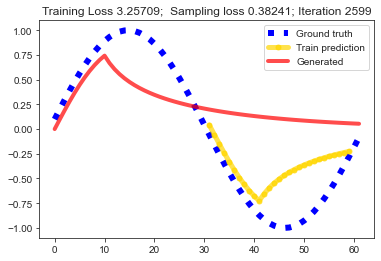

[2800] avg_loss: 3.47671, report_loss: 0.36201, 


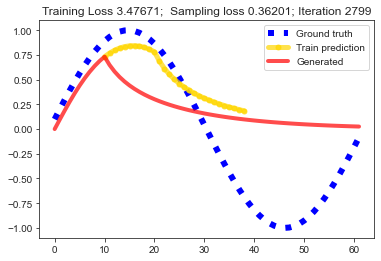

[3000] avg_loss: 3.70036, report_loss: 0.35497, 


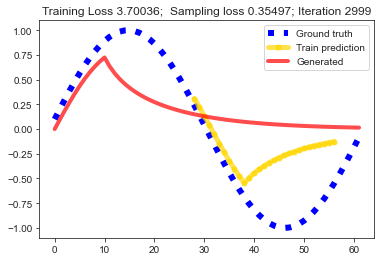

[3200] avg_loss: 3.91434, report_loss: 0.39295, 


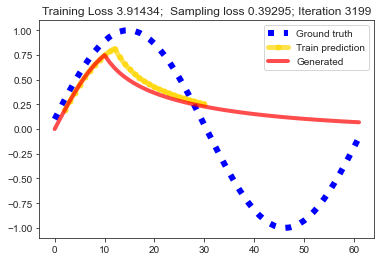

[3400] avg_loss: 4.14723, report_loss: 0.36437, 


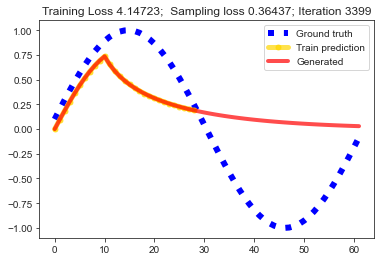

[3600] avg_loss: 4.36447, report_loss: 0.37185, 


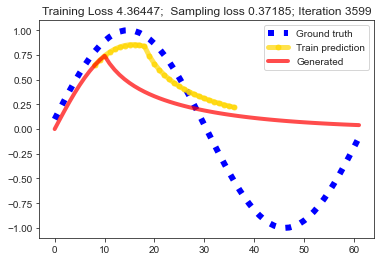

[3800] avg_loss: 4.59507, report_loss: 0.35941, 


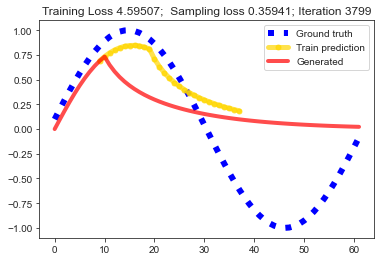

[4000] avg_loss: 4.82183, report_loss: 0.36109, 


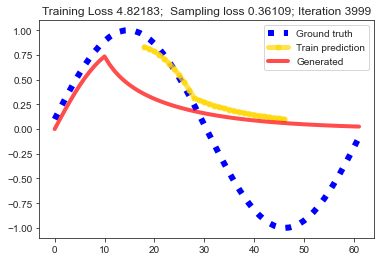

[4200] avg_loss: 5.05182, report_loss: 0.35145, 


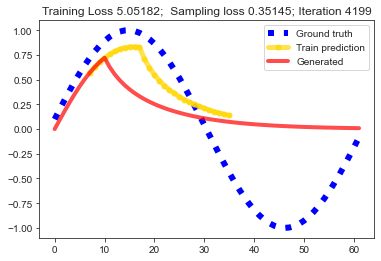

[4400] avg_loss: 5.26773, report_loss: 0.43355, 


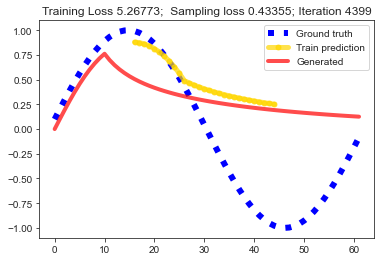

[4600] avg_loss: 5.50248, report_loss: 0.36614, 


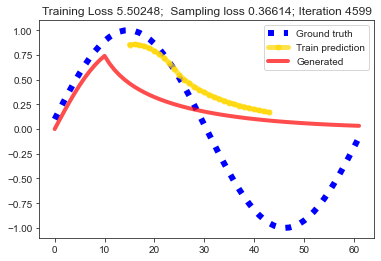

[4800] avg_loss: 5.72751, report_loss: 0.35496, 


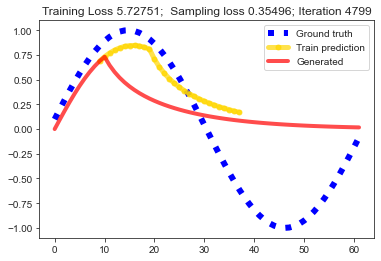

[5000] avg_loss: 5.94679, report_loss: 0.35366, 


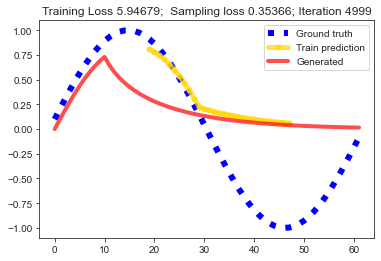

[5200] avg_loss: 6.18813, report_loss: 0.35205, 


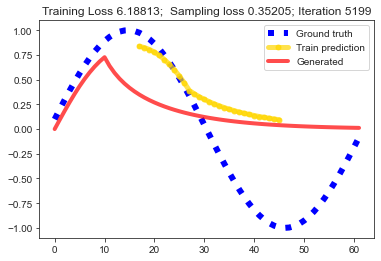

[5400] avg_loss: 6.40189, report_loss: 0.38557, 


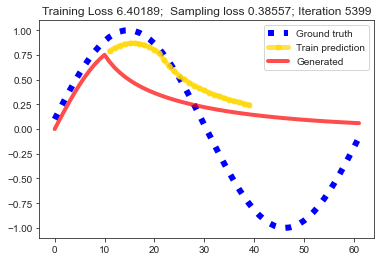

[5600] avg_loss: 6.62287, report_loss: 0.35861, 


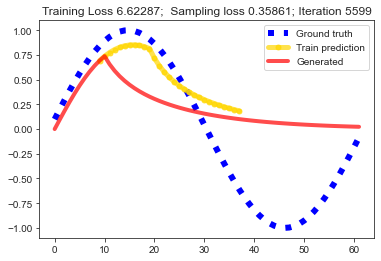

[5800] avg_loss: 6.84299, report_loss: 0.35252, 


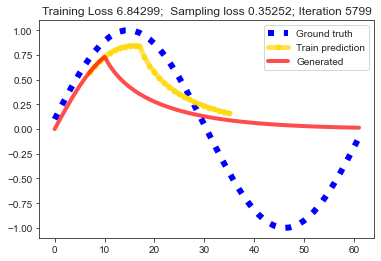

[6000] avg_loss: 7.07629, report_loss: 0.36670, 


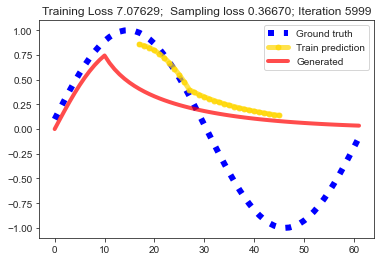

[6200] avg_loss: 7.29863, report_loss: 0.35464, 


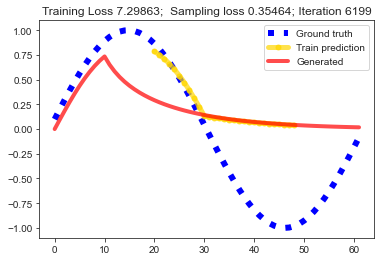

[6400] avg_loss: 7.51403, report_loss: 0.41084, 


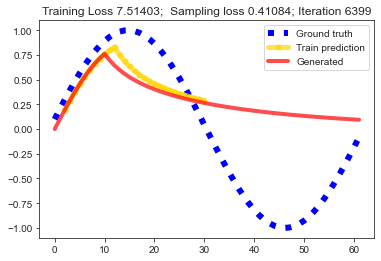

[6600] avg_loss: 7.73404, report_loss: 0.37354, 


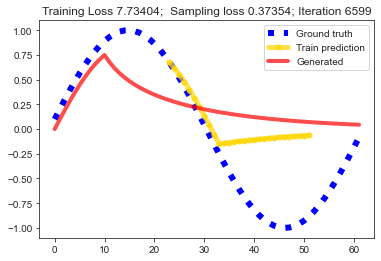

[6800] avg_loss: 7.95230, report_loss: 0.38539, 


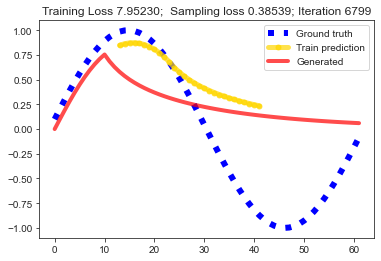

[7000] avg_loss: 8.18223, report_loss: 0.37020, 


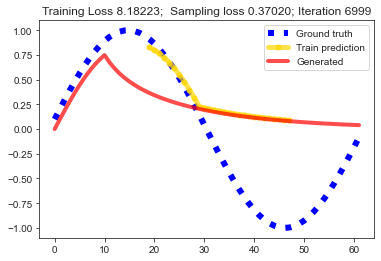

[7200] avg_loss: 8.40835, report_loss: 0.37690, 


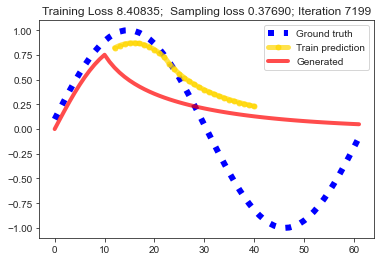

[7400] avg_loss: 8.63448, report_loss: 0.35699, 


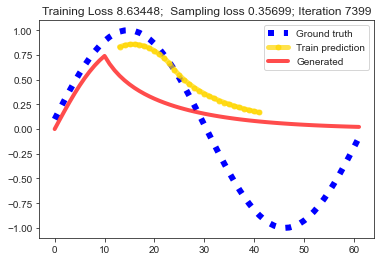

[7600] avg_loss: 8.88275, report_loss: 0.36934, 


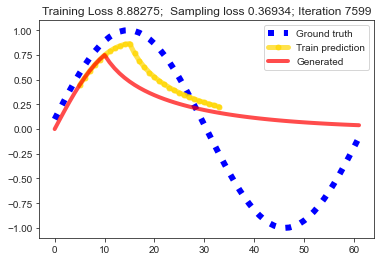

[7800] avg_loss: 9.09789, report_loss: 0.36610, 


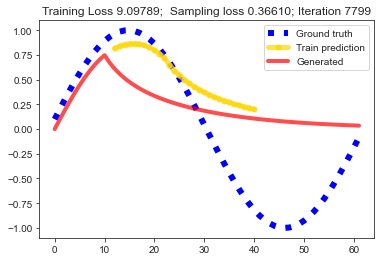

[8000] avg_loss: 9.32325, report_loss: 0.35047, 


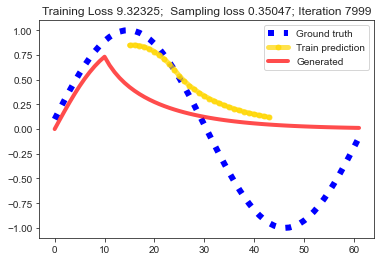

[8200] avg_loss: 9.53447, report_loss: 0.37646, 


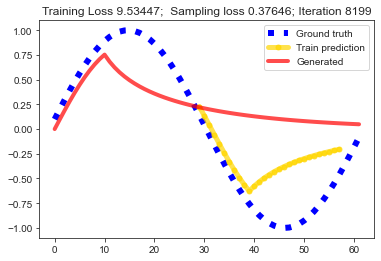

[8400] avg_loss: 9.75920, report_loss: 0.35838, 


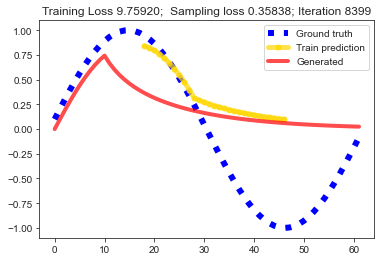

[8600] avg_loss: 9.97476, report_loss: 0.34890, 


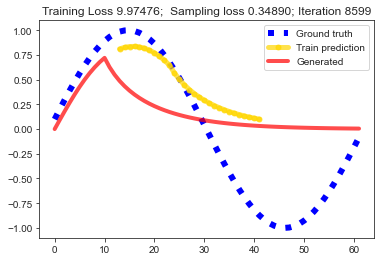

[8800] avg_loss: 10.20903, report_loss: 0.34855, 


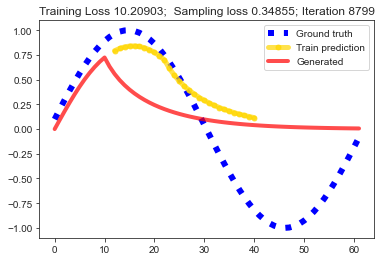

[9000] avg_loss: 10.43165, report_loss: 0.35129, 


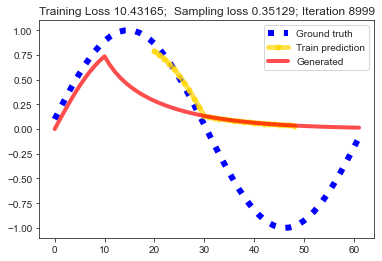

[9200] avg_loss: 10.64929, report_loss: 0.35929, 


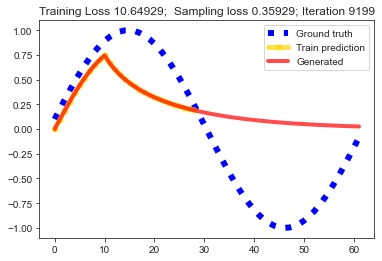

[9400] avg_loss: 10.86066, report_loss: 0.36791, 


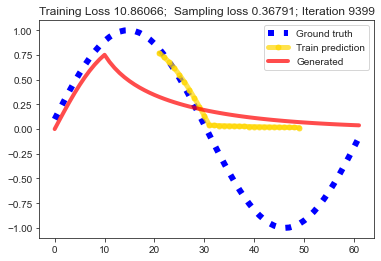

[9600] avg_loss: 11.07589, report_loss: 0.35127, 


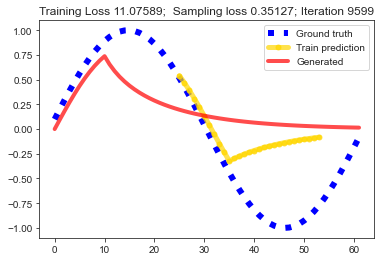

[9800] avg_loss: 11.28088, report_loss: 0.37887, 


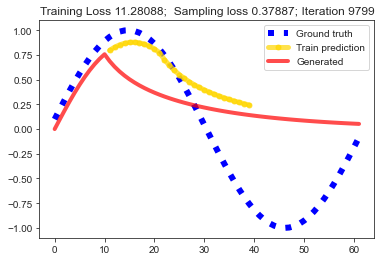

[10000] avg_loss: 11.49822, report_loss: 0.38741, 


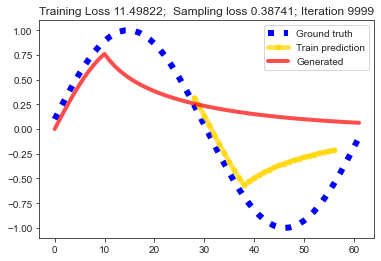

In [4]:
UNROLL_LENGTH = 30  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING = False  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.0001  #@param {type:"number"}
REPORTING_INTERVAL = 200  #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=False)
net.train()
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    start = np.random.choice(range(x_train.shape[0] - UNROLL_LENGTH))
    train_sequence = y_train[start : (start + UNROLL_LENGTH)]
    
    train_inputs = torch.from_numpy(train_sequence[:-1]).float().to(device)
    train_targets = torch.from_numpy(train_sequence[1:]).float().to(device)
    
    optimizer.zero_grad()
    
    outputs, hidden = net(train_inputs, hidden=None, force=TEACHER_FORCING, warm_start=WARM_START)
    loss = criterion(outputs, train_targets)
    loss.backward()
    
    running_loss += loss.item()
    
    optimizer.step()
    
    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        
        report_sequence = torch.from_numpy(y_train[:-1]).float().to(device)
        report_targets = torch.from_numpy(y_train[1:]).float().to(device)
        report_output, report_hidden = net(report_sequence, hidden=None, force=False, warm_start=WARM_START)
        
        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))
        
        plt.figure()
        plt.title('Training Loss %.5f;  Sampling loss %.5f; Iteration %d' % (avg_loss, report_loss.item(), iteration))
        
        plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
        plt.plot(range(start, start+UNROLL_LENGTH-1), outputs.data.numpy().ravel(), c='gold',
               label='Train prediction', lw=5, marker="o", markersize=5,
               alpha=0.7)
        plt.plot(report_output.data.numpy().ravel(), c='r', label='Generated', lw=4, alpha=0.7)
        plt.legend()
        plt.show()

### Experiments

- default hyper without teacher forcing

In [6]:
UNROLL_LENGTH = 30  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING = False  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.0001  #@param {type:"number"}
REPORTING_INTERVAL = 200  #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=False)
net.train()
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    start = np.random.choice(range(x_train.shape[0] - UNROLL_LENGTH))
    train_sequence = y_train[start : (start + UNROLL_LENGTH)]
    
    train_inputs = torch.from_numpy(train_sequence[:-1]).float().to(device)
    train_targets = torch.from_numpy(train_sequence[1:]).float().to(device)
    
    optimizer.zero_grad()
    
    outputs, hidden = net(train_inputs, hidden=None, force=TEACHER_FORCING, warm_start=WARM_START)
    loss = criterion(outputs, train_targets)
    loss.backward()
    
    running_loss += loss.item()
    
    optimizer.step()
    
    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        
        report_sequence = torch.from_numpy(y_train[:-1]).float().to(device)
        report_targets = torch.from_numpy(y_train[1:]).float().to(device)
        report_output, report_hidden = net(report_sequence, hidden=None, force=False, warm_start=WARM_START)
        
        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))

[200] avg_loss: 0.42934, report_loss: 0.45791, 
[400] avg_loss: 0.71941, report_loss: 0.35122, 
[600] avg_loss: 0.94114, report_loss: 0.44489, 
[800] avg_loss: 1.15834, report_loss: 0.35150, 
[1000] avg_loss: 1.38547, report_loss: 0.39359, 
[1200] avg_loss: 1.59713, report_loss: 0.35161, 
[1400] avg_loss: 1.80722, report_loss: 0.35139, 
[1600] avg_loss: 2.02019, report_loss: 0.39690, 
[1800] avg_loss: 2.25830, report_loss: 0.35167, 
[2000] avg_loss: 2.47762, report_loss: 0.36258, 
[2200] avg_loss: 2.68584, report_loss: 0.34831, 
[2400] avg_loss: 2.92235, report_loss: 0.34759, 
[2600] avg_loss: 3.14916, report_loss: 0.37553, 
[2800] avg_loss: 3.37078, report_loss: 0.35120, 
[3000] avg_loss: 3.59177, report_loss: 0.36017, 
[3200] avg_loss: 3.81847, report_loss: 0.34881, 
[3400] avg_loss: 4.04572, report_loss: 0.35062, 
[3600] avg_loss: 4.27131, report_loss: 0.39117, 
[3800] avg_loss: 4.47984, report_loss: 0.45177, 
[4000] avg_loss: 4.69927, report_loss: 0.34667, 
[4200] avg_loss: 4.91061

[200] avg_loss: 0.23691, report_loss: 0.44083, 


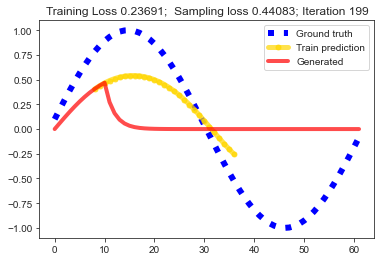

[400] avg_loss: 0.28180, report_loss: 0.35862, 


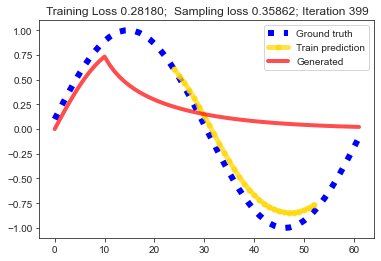

[600] avg_loss: 0.28924, report_loss: 1.00449, 


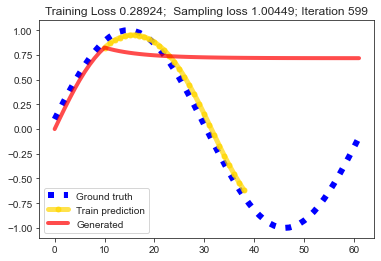

[800] avg_loss: 0.29462, report_loss: 1.14963, 


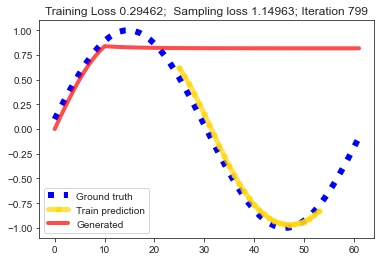

[1000] avg_loss: 0.29988, report_loss: 1.16625, 


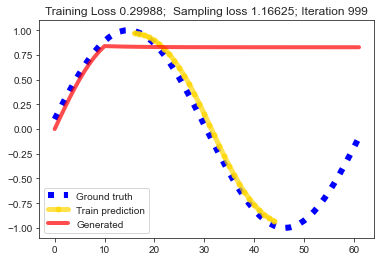

[1200] avg_loss: 0.30518, report_loss: 1.15377, 


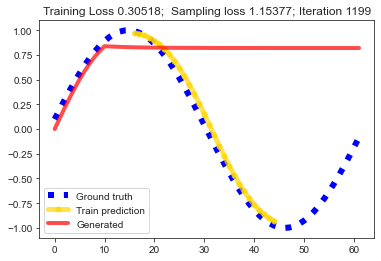

[1400] avg_loss: 0.31047, report_loss: 1.15844, 


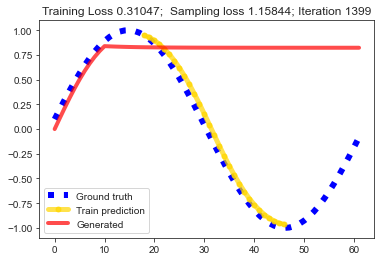

[1600] avg_loss: 0.31571, report_loss: 1.16292, 


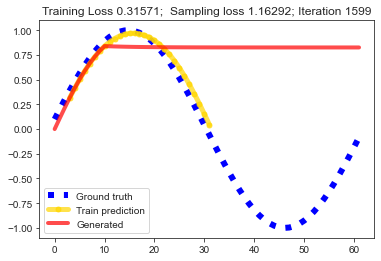

[1800] avg_loss: 0.32100, report_loss: 1.15628, 


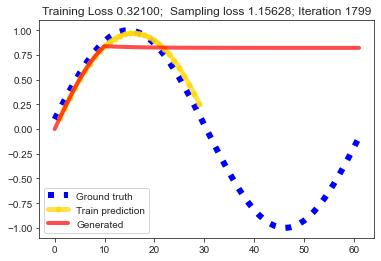

[2000] avg_loss: 0.32632, report_loss: 1.15042, 


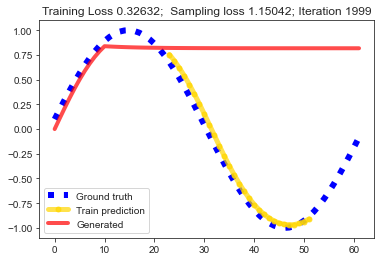

[2200] avg_loss: 0.33158, report_loss: 1.16227, 


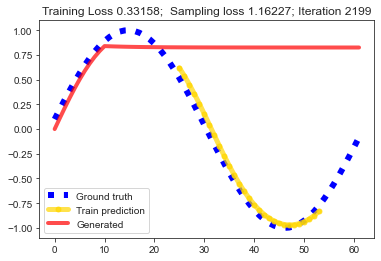

[2400] avg_loss: 0.33682, report_loss: 1.15162, 


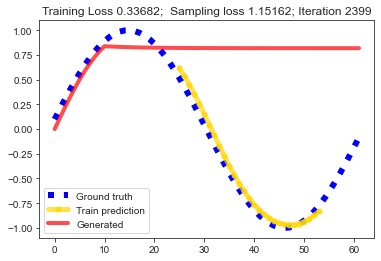

[2600] avg_loss: 0.34204, report_loss: 1.16552, 


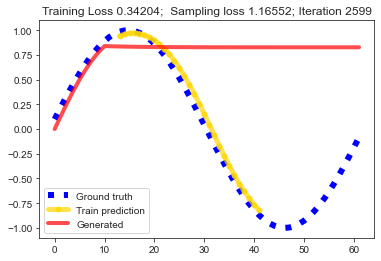

[2800] avg_loss: 0.34724, report_loss: 1.17852, 


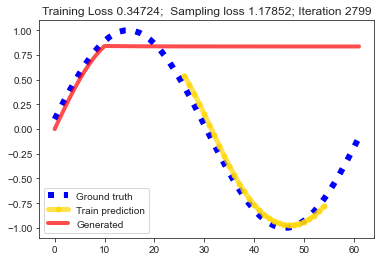

[3000] avg_loss: 0.35247, report_loss: 1.14720, 


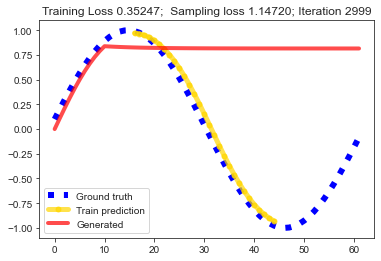

[3200] avg_loss: 0.35773, report_loss: 1.15580, 


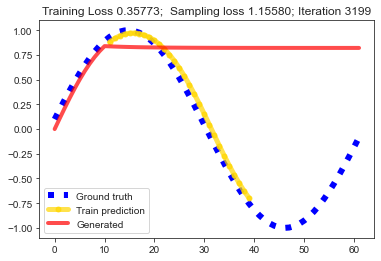

[3400] avg_loss: 0.36291, report_loss: 1.15871, 


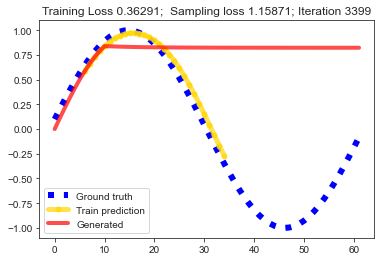

[3600] avg_loss: 0.36810, report_loss: 1.15611, 


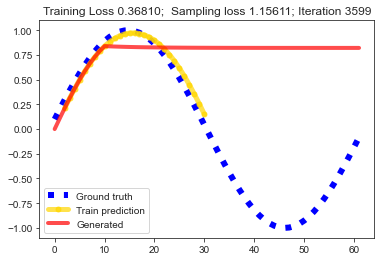

[3800] avg_loss: 0.37329, report_loss: 1.15222, 


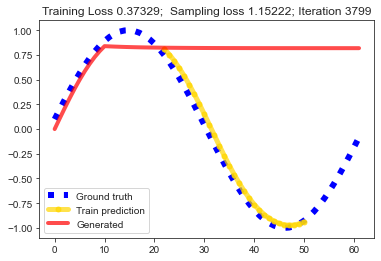

[4000] avg_loss: 0.37853, report_loss: 1.14026, 


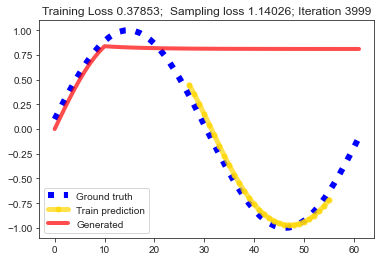

[4200] avg_loss: 0.38372, report_loss: 1.13030, 


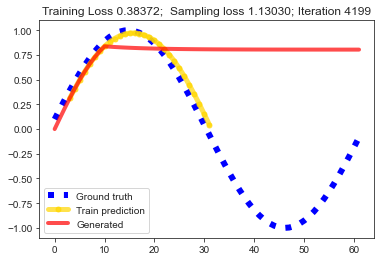

[4400] avg_loss: 0.38889, report_loss: 1.16678, 


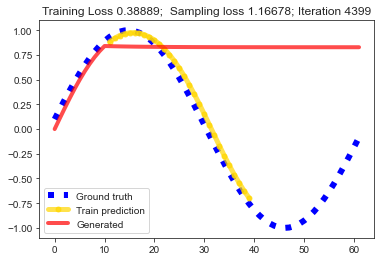

[4600] avg_loss: 0.39401, report_loss: 1.15899, 


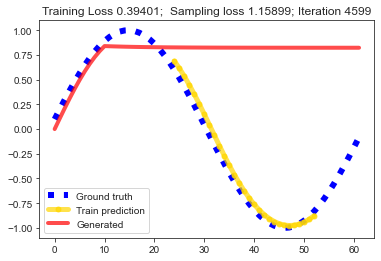

[4800] avg_loss: 0.39917, report_loss: 1.12780, 


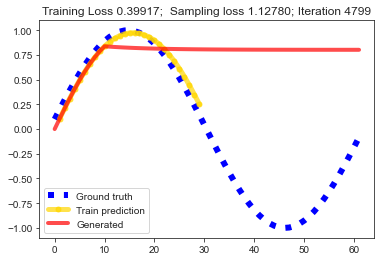

[5000] avg_loss: 0.40432, report_loss: 1.13131, 


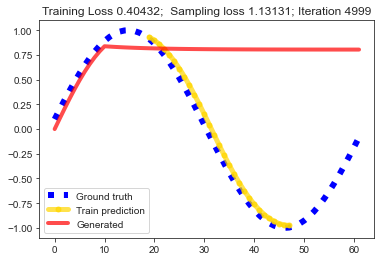

[5200] avg_loss: 0.40945, report_loss: 1.11226, 


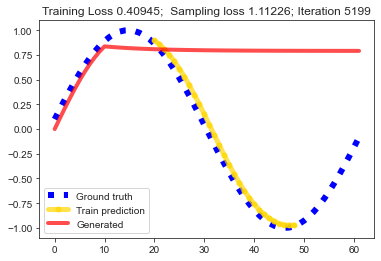

[5400] avg_loss: 0.41458, report_loss: 1.15983, 


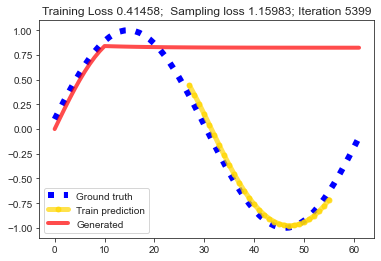

[5600] avg_loss: 0.41969, report_loss: 1.15248, 


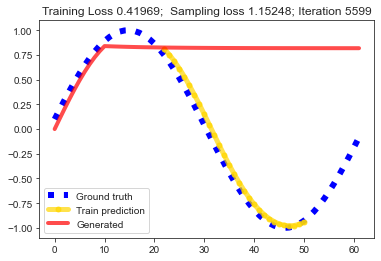

[5800] avg_loss: 0.42480, report_loss: 1.17698, 


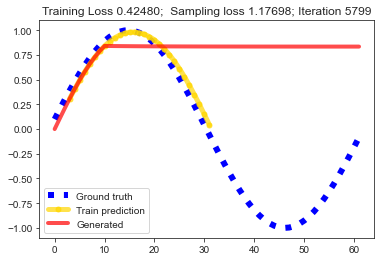

[6000] avg_loss: 0.42990, report_loss: 1.13599, 


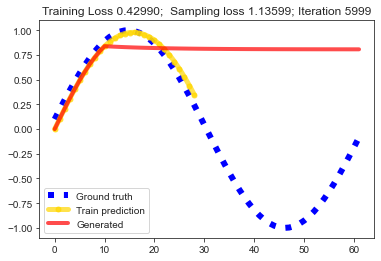

[6200] avg_loss: 0.43496, report_loss: 1.14703, 


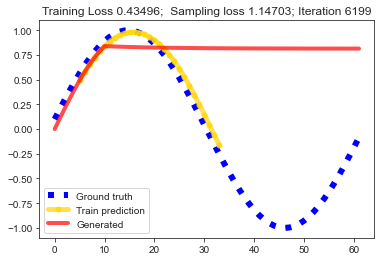

[6400] avg_loss: 0.44000, report_loss: 1.15803, 


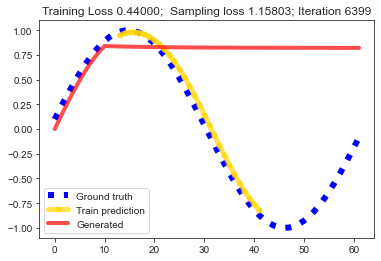

[6600] avg_loss: 0.44505, report_loss: 1.19618, 


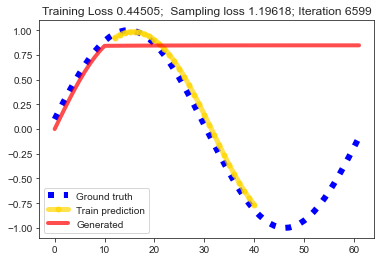

[6800] avg_loss: 0.45013, report_loss: 1.19591, 


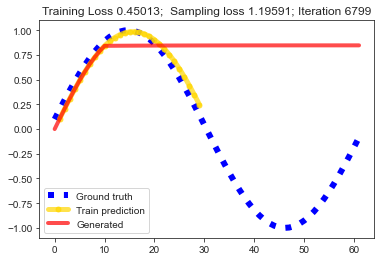

[7000] avg_loss: 0.45513, report_loss: 1.10192, 


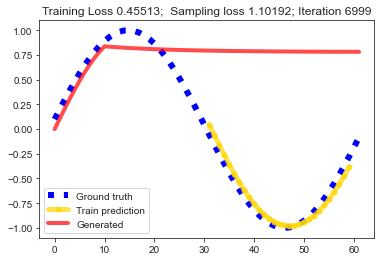

[7200] avg_loss: 0.46018, report_loss: 1.16167, 


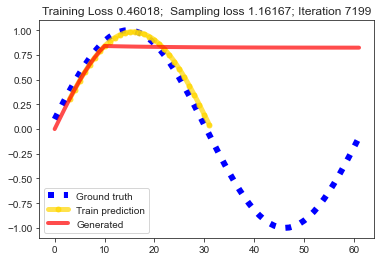

[7400] avg_loss: 0.46520, report_loss: 1.11504, 


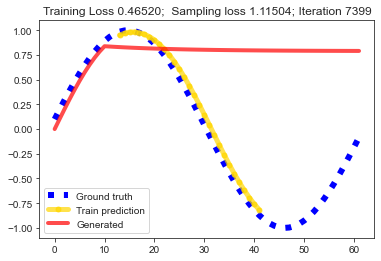

[7600] avg_loss: 0.47025, report_loss: 1.20175, 


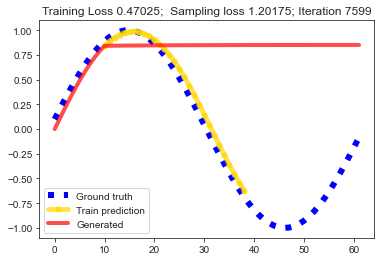

[7800] avg_loss: 0.47532, report_loss: 1.16108, 


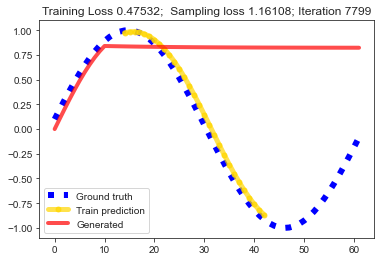

[8000] avg_loss: 0.48034, report_loss: 1.07006, 


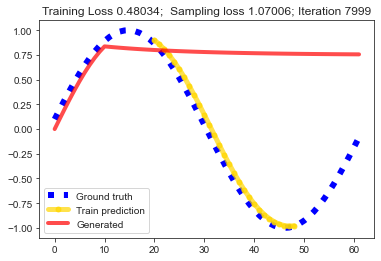

[8200] avg_loss: 0.48538, report_loss: 1.09803, 


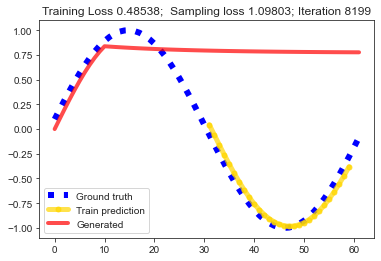

[8400] avg_loss: 0.49041, report_loss: 1.04534, 


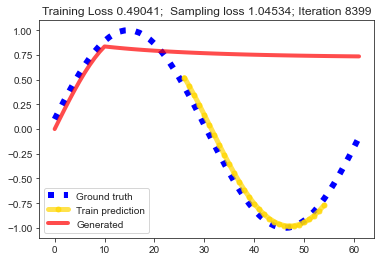

[8600] avg_loss: 0.49541, report_loss: 1.14595, 


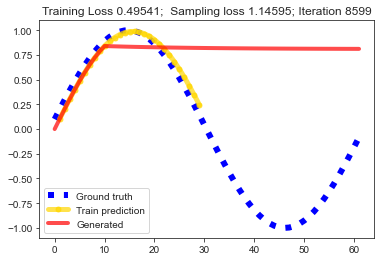

[8800] avg_loss: 0.50042, report_loss: 1.03107, 


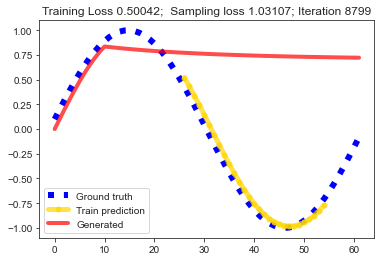

[9000] avg_loss: 0.50537, report_loss: 1.13608, 


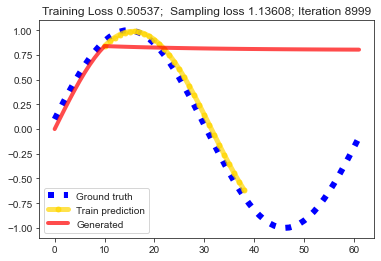

[9200] avg_loss: 0.51037, report_loss: 1.11071, 


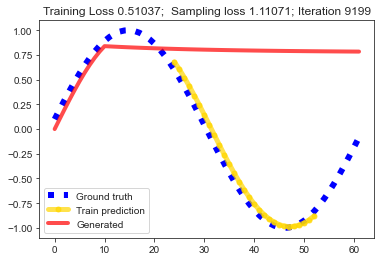

[9400] avg_loss: 0.51535, report_loss: 0.99941, 


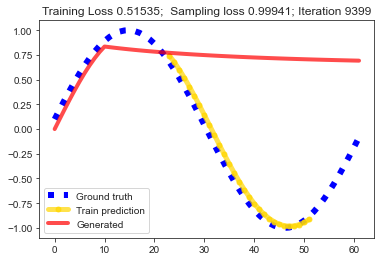

[9600] avg_loss: 0.52033, report_loss: 1.07841, 


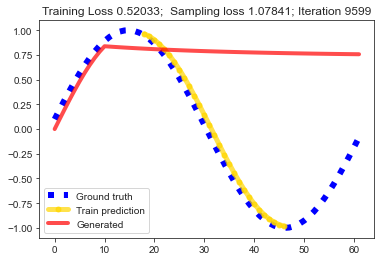

[9800] avg_loss: 0.52533, report_loss: 1.10997, 


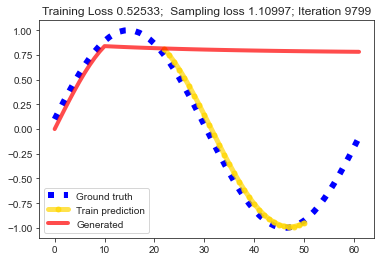

[10000] avg_loss: 0.53031, report_loss: 1.13736, 


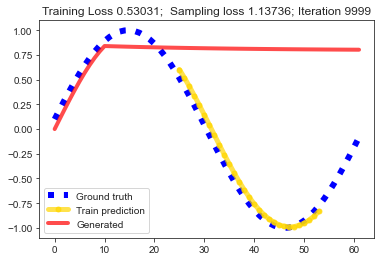

In [9]:
UNROLL_LENGTH = 30  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING = True  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.0001  #@param {type:"number"}
REPORTING_INTERVAL = 200  #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=False)
net.train()
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    start = np.random.choice(range(x_train.shape[0] - UNROLL_LENGTH))
    train_sequence = y_train[start : (start + UNROLL_LENGTH)]
    
    train_inputs = torch.from_numpy(train_sequence[:-1]).float().to(device)
    train_targets = torch.from_numpy(train_sequence[1:]).float().to(device)
    
    optimizer.zero_grad()
    
    outputs, hidden = net(train_inputs, hidden=None, force=TEACHER_FORCING, warm_start=WARM_START)
    loss = criterion(outputs, train_targets)
    loss.backward()
    
    running_loss += loss.item()
    
    optimizer.step()
    
    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        
        report_sequence = torch.from_numpy(y_train[:-1]).float().to(device)
        report_targets = torch.from_numpy(y_train[1:]).float().to(device)
        report_output, report_hidden = net(report_sequence, hidden=None, force=False, warm_start=WARM_START)
        
        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))
        
        plt.figure()
        plt.title('Training Loss %.5f;  Sampling loss %.5f; Iteration %d' % (avg_loss, report_loss.item(), iteration))
        
        plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
        plt.plot(range(start, start+UNROLL_LENGTH-1), outputs.data.numpy().ravel(), c='gold',
               label='Train prediction', lw=5, marker="o", markersize=5,
               alpha=0.7)
        plt.plot(report_output.data.numpy().ravel(), c='r', label='Generated', lw=4, alpha=0.7)
        plt.legend()
        plt.show()

### Experiments on sequence length

[200] avg_loss: 0.27725, report_loss: 0.44703, 


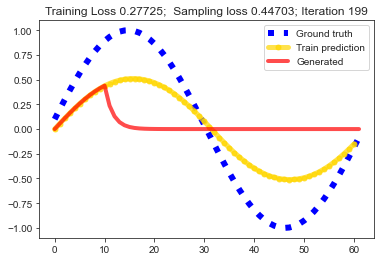

[400] avg_loss: 0.32942, report_loss: 0.34862, 


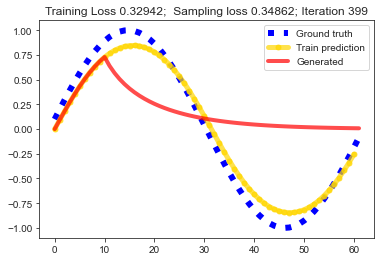

[600] avg_loss: 0.33681, report_loss: 0.98866, 


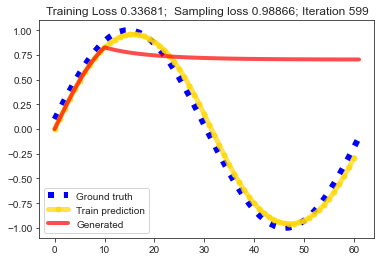

[800] avg_loss: 0.34186, report_loss: 1.15351, 


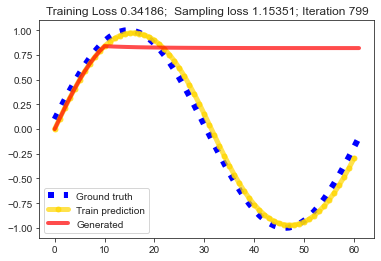

[1000] avg_loss: 0.34689, report_loss: 1.16311, 


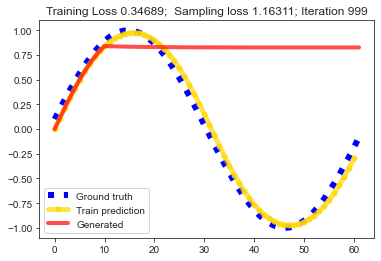

[1200] avg_loss: 0.35191, report_loss: 1.16332, 


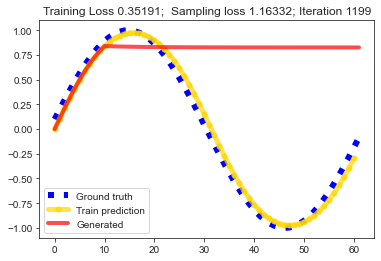

[1400] avg_loss: 0.35693, report_loss: 1.16324, 


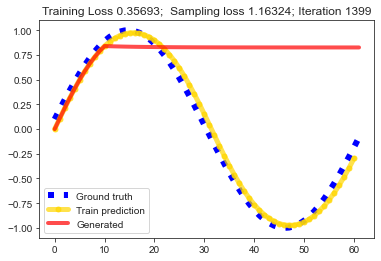

[1600] avg_loss: 0.36195, report_loss: 1.16313, 


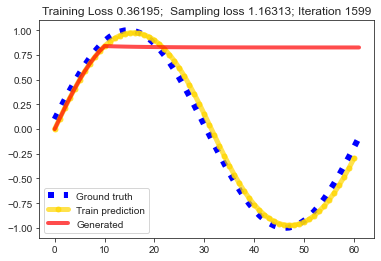

[1800] avg_loss: 0.36697, report_loss: 1.16302, 


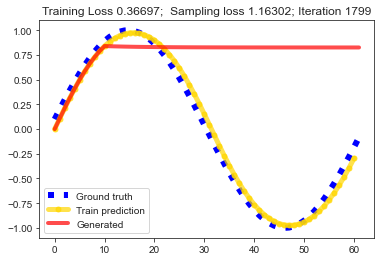

[2000] avg_loss: 0.37198, report_loss: 1.16289, 


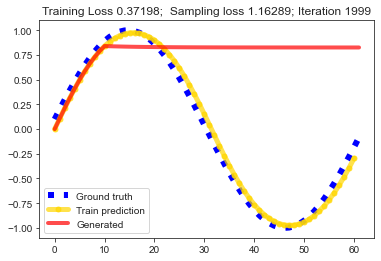

[2200] avg_loss: 0.37699, report_loss: 1.16274, 


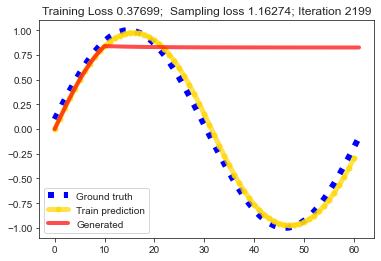

[2400] avg_loss: 0.38200, report_loss: 1.16257, 


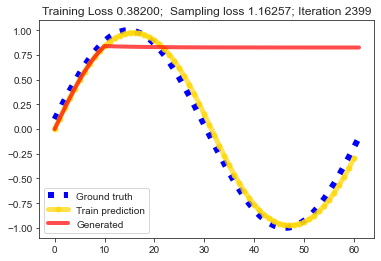

[2600] avg_loss: 0.38701, report_loss: 1.16237, 


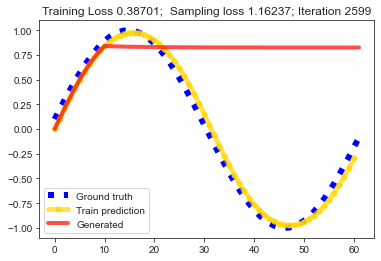

[2800] avg_loss: 0.39201, report_loss: 1.16214, 


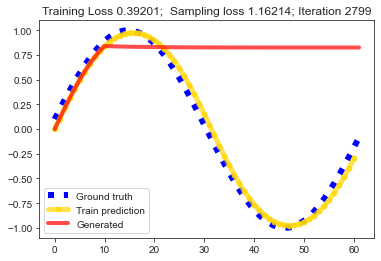

[3000] avg_loss: 0.39700, report_loss: 1.16189, 


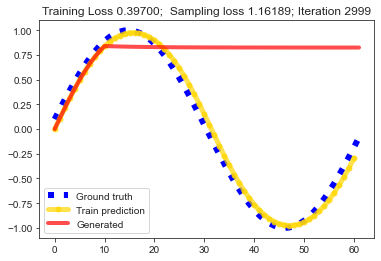

[3200] avg_loss: 0.40199, report_loss: 1.16161, 


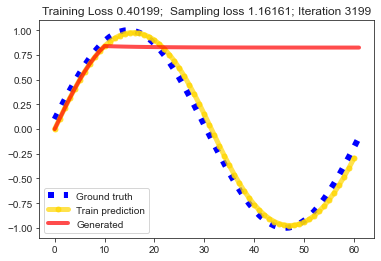

[3400] avg_loss: 0.40698, report_loss: 1.16128, 


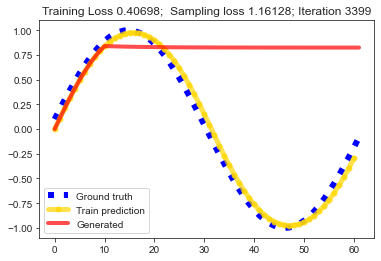

[3600] avg_loss: 0.41196, report_loss: 1.16092, 


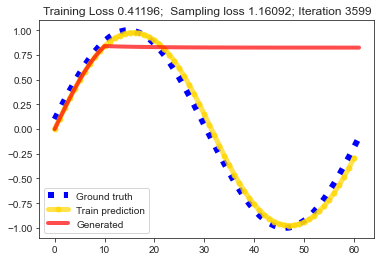

[3800] avg_loss: 0.41694, report_loss: 1.16052, 


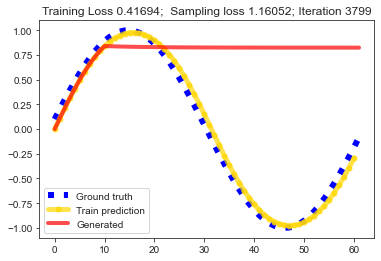

[4000] avg_loss: 0.42191, report_loss: 1.16007, 


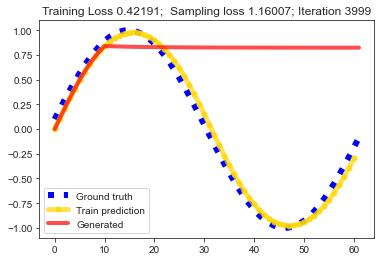

[4200] avg_loss: 0.42688, report_loss: 1.15957, 


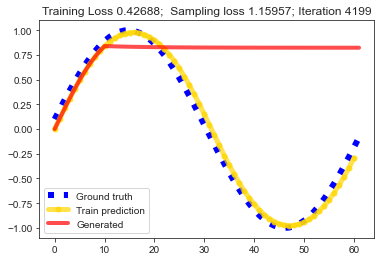

[4400] avg_loss: 0.43184, report_loss: 1.15901, 


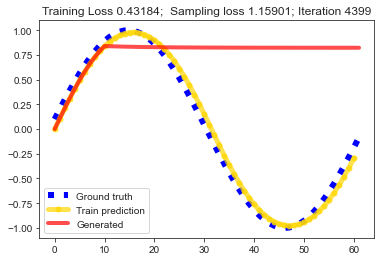

[4600] avg_loss: 0.43679, report_loss: 1.15840, 


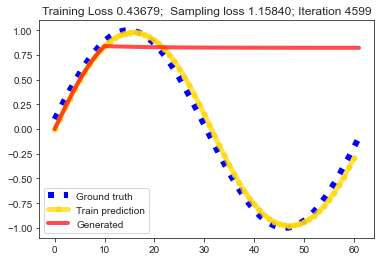

[4800] avg_loss: 0.44174, report_loss: 1.15773, 


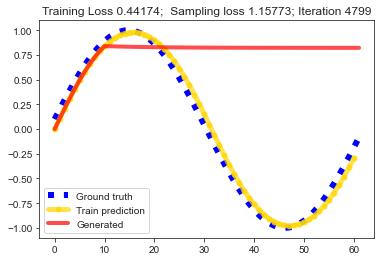

[5000] avg_loss: 0.44669, report_loss: 1.15701, 


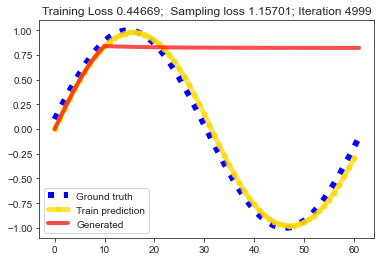

[5200] avg_loss: 0.45163, report_loss: 1.15622, 


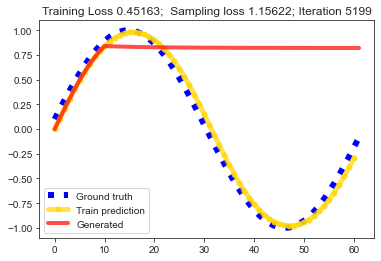

[5400] avg_loss: 0.45657, report_loss: 1.15538, 


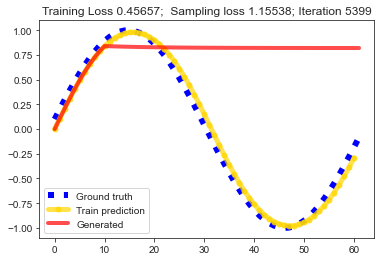

[5600] avg_loss: 0.46150, report_loss: 1.15447, 


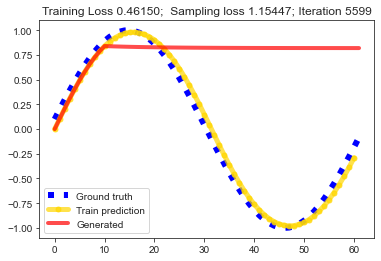

[5800] avg_loss: 0.46642, report_loss: 1.15350, 


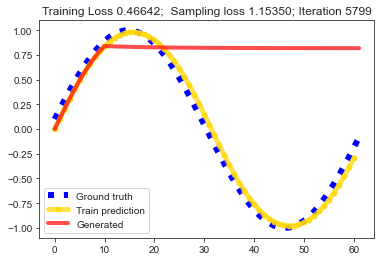

[6000] avg_loss: 0.47134, report_loss: 1.15247, 


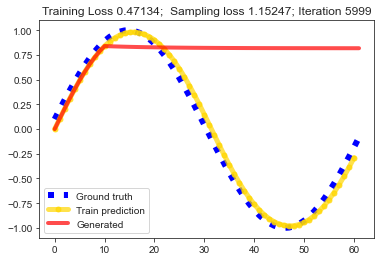

[6200] avg_loss: 0.47626, report_loss: 1.15139, 


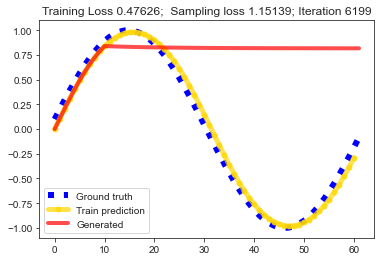

[6400] avg_loss: 0.48117, report_loss: 1.15026, 


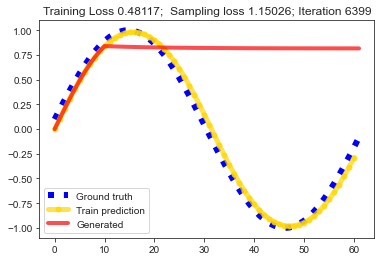

[6600] avg_loss: 0.48607, report_loss: 1.14906, 


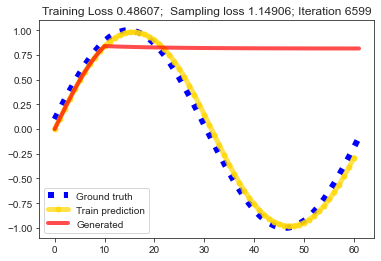

[6800] avg_loss: 0.49098, report_loss: 1.14782, 


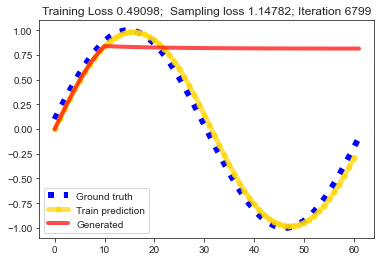

[7000] avg_loss: 0.49587, report_loss: 1.14652, 


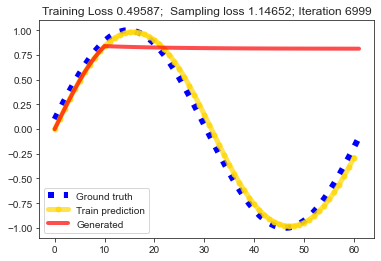

[7200] avg_loss: 0.50077, report_loss: 1.14517, 


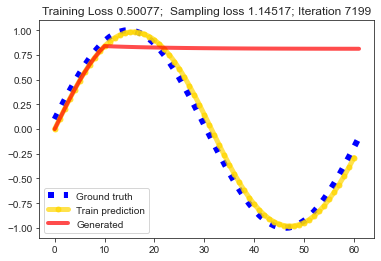

[7400] avg_loss: 0.50566, report_loss: 1.14378, 


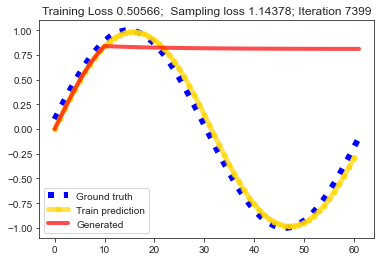

[7600] avg_loss: 0.51055, report_loss: 1.14234, 


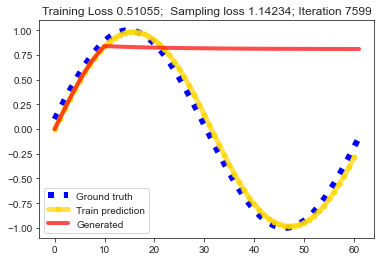

[7800] avg_loss: 0.51543, report_loss: 1.14085, 


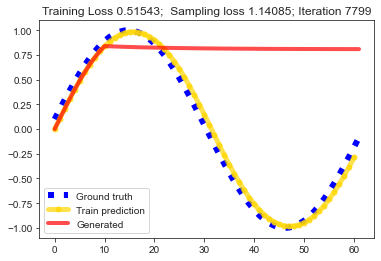

[8000] avg_loss: 0.52031, report_loss: 1.13933, 


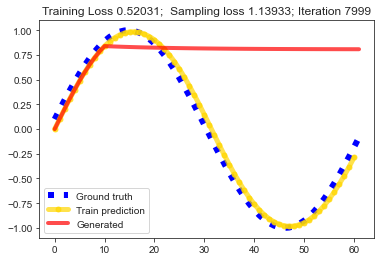

[8200] avg_loss: 0.52519, report_loss: 1.13777, 


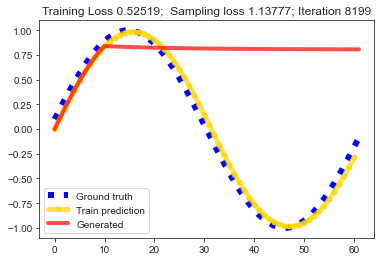

[8400] avg_loss: 0.53006, report_loss: 1.13618, 


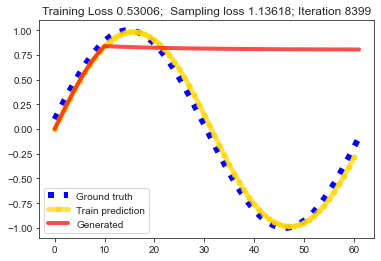

[8600] avg_loss: 0.53493, report_loss: 1.13456, 


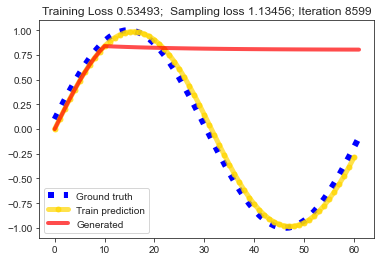

[8800] avg_loss: 0.53980, report_loss: 1.13292, 


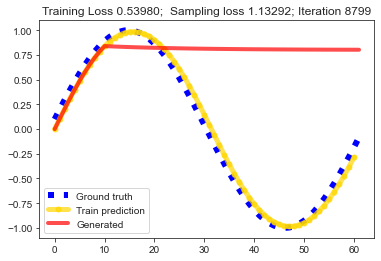

[9000] avg_loss: 0.54467, report_loss: 1.13126, 


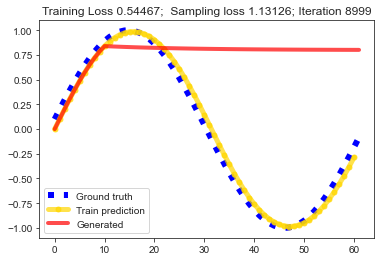

[9200] avg_loss: 0.54953, report_loss: 1.12959, 


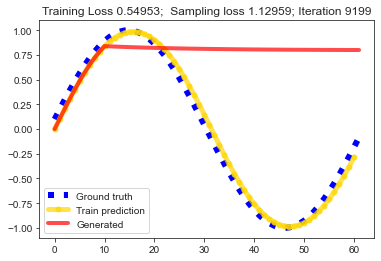

[9400] avg_loss: 0.55440, report_loss: 1.12792, 


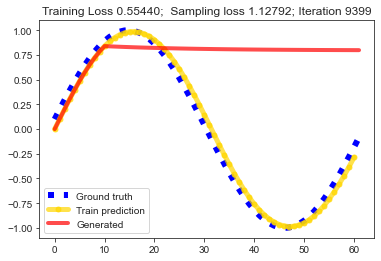

[9600] avg_loss: 0.55926, report_loss: 1.12626, 


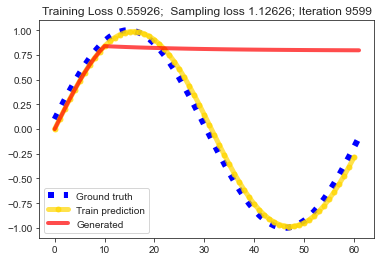

[9800] avg_loss: 0.56412, report_loss: 1.12460, 


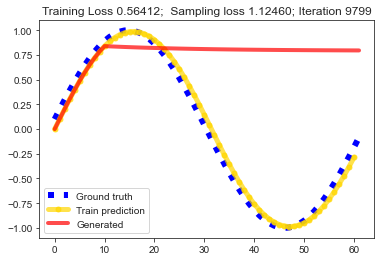

[10000] avg_loss: 0.56897, report_loss: 1.12295, 


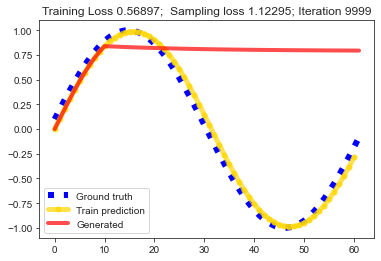

In [10]:
UNROLL_LENGTH = 62  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING = True  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.0001  #@param {type:"number"}
REPORTING_INTERVAL = 200  #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=False)
net.train()
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    start = np.random.choice(range(x_train.shape[0] - UNROLL_LENGTH))
    train_sequence = y_train[start : (start + UNROLL_LENGTH)]
    
    train_inputs = torch.from_numpy(train_sequence[:-1]).float().to(device)
    train_targets = torch.from_numpy(train_sequence[1:]).float().to(device)
    
    optimizer.zero_grad()
    
    outputs, hidden = net(train_inputs, hidden=None, force=TEACHER_FORCING, warm_start=WARM_START)
    loss = criterion(outputs, train_targets)
    loss.backward()
    
    running_loss += loss.item()
    
    optimizer.step()
    
    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        
        report_sequence = torch.from_numpy(y_train[:-1]).float().to(device)
        report_targets = torch.from_numpy(y_train[1:]).float().to(device)
        report_output, report_hidden = net(report_sequence, hidden=None, force=False, warm_start=WARM_START)
        
        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))
        
        plt.figure()
        plt.title('Training Loss %.5f;  Sampling loss %.5f; Iteration %d' % (avg_loss, report_loss.item(), iteration))
        
        plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
        plt.plot(range(start, start+UNROLL_LENGTH-1), outputs.data.numpy().ravel(), c='gold',
               label='Train prediction', lw=5, marker="o", markersize=5,
               alpha=0.7)
        plt.plot(report_output.data.numpy().ravel(), c='r', label='Generated', lw=4, alpha=0.7)
        plt.legend()
        plt.show()

For unroll_length of 62 (full) and no teacher forcing we can clearly see an improvement in the quality of the generated sequences.

[200] avg_loss: 0.48413, report_loss: 0.42707, 


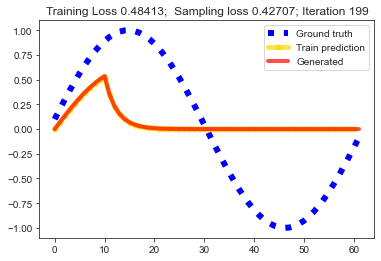

[400] avg_loss: 0.84536, report_loss: 0.34652, 


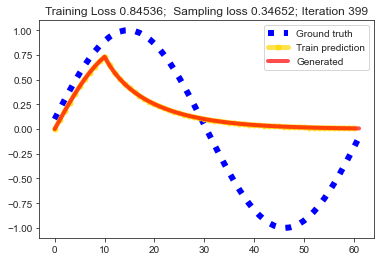

[600] avg_loss: 1.19639, report_loss: 0.34444, 


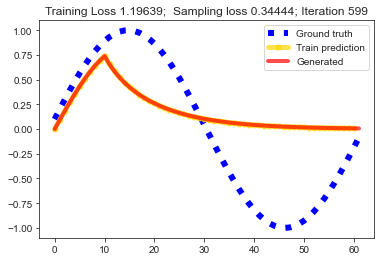

[800] avg_loss: 1.54521, report_loss: 0.34212, 


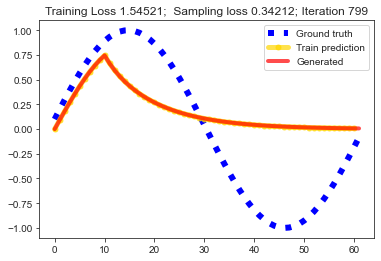

[1000] avg_loss: 1.89124, report_loss: 0.33865, 


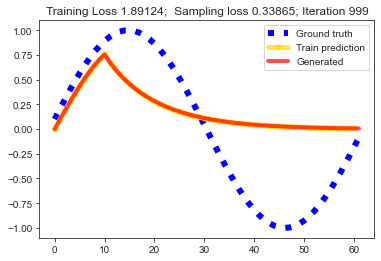

[1200] avg_loss: 2.23157, report_loss: 0.32931, 


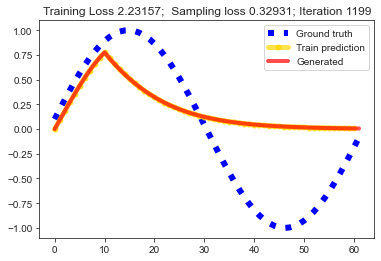

[1400] avg_loss: 2.55244, report_loss: 0.29774, 


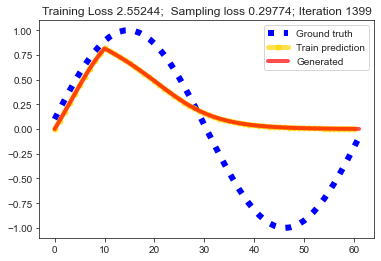

[1600] avg_loss: 2.84067, report_loss: 0.27451, 


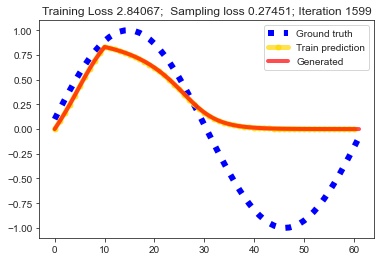

[1800] avg_loss: 3.11589, report_loss: 0.26840, 


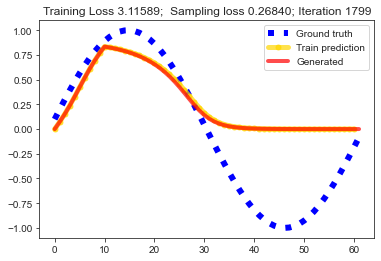

[2000] avg_loss: 3.38716, report_loss: 0.26593, 


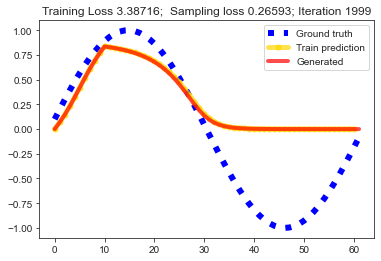

[2200] avg_loss: 3.65665, report_loss: 0.26465, 


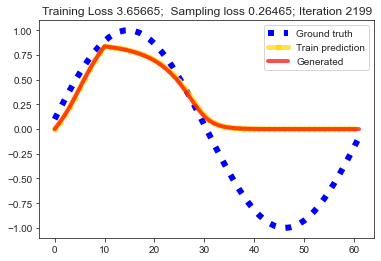

[2400] avg_loss: 3.92512, report_loss: 0.26387, 


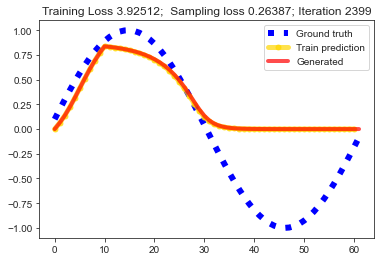

[2600] avg_loss: 4.19295, report_loss: 0.26337, 


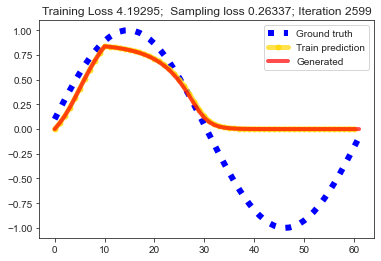

[2800] avg_loss: 4.46034, report_loss: 0.26299, 


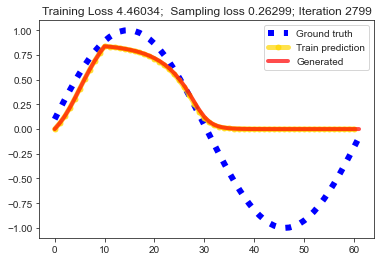

[3000] avg_loss: 4.72741, report_loss: 0.26285, 


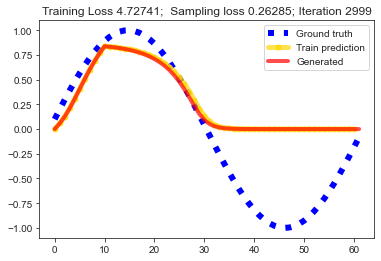

[3200] avg_loss: 4.99424, report_loss: 0.26250, 


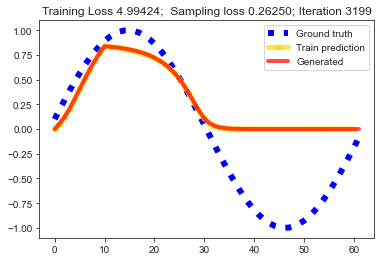

[3400] avg_loss: 5.26088, report_loss: 0.26241, 


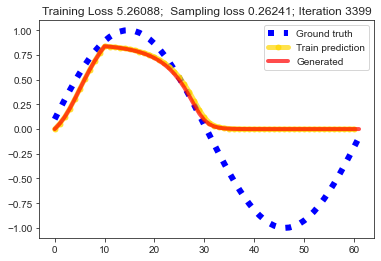

[3600] avg_loss: 5.52738, report_loss: 0.26228, 


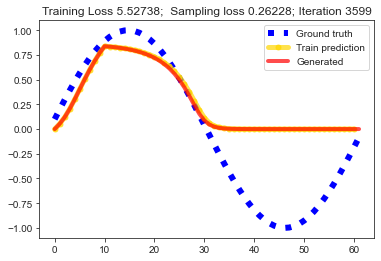

[3800] avg_loss: 5.79377, report_loss: 0.26211, 


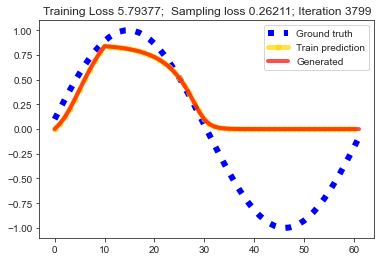

[4000] avg_loss: 6.06006, report_loss: 0.26204, 


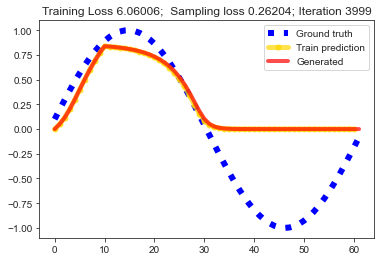

[4200] avg_loss: 6.32627, report_loss: 0.26196, 


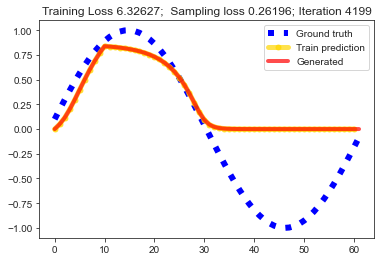

[4400] avg_loss: 6.59242, report_loss: 0.26193, 


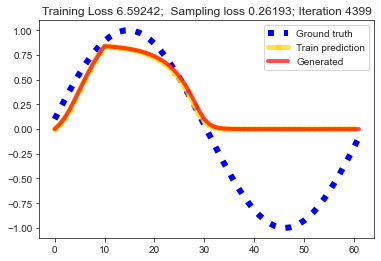

[4600] avg_loss: 6.85852, report_loss: 0.26186, 


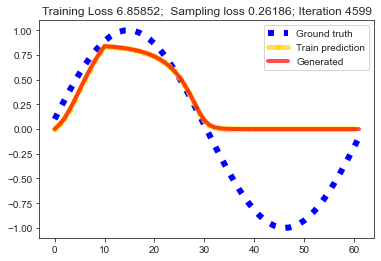

[4800] avg_loss: 7.12458, report_loss: 0.26183, 


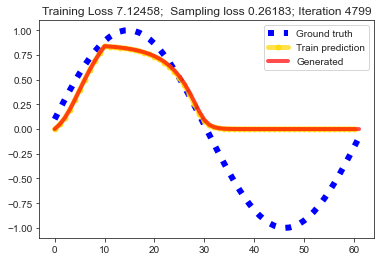

[5000] avg_loss: 7.39060, report_loss: 0.26188, 


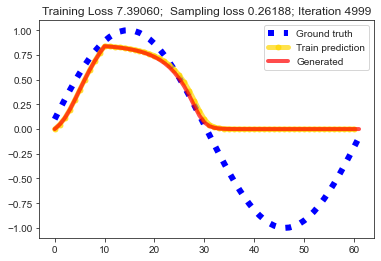

[5200] avg_loss: 7.65659, report_loss: 0.26191, 


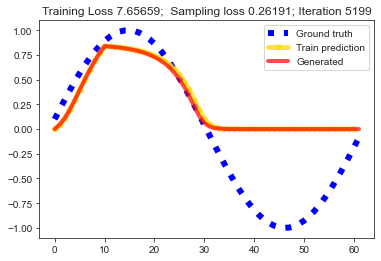

[5400] avg_loss: 7.92256, report_loss: 0.26183, 


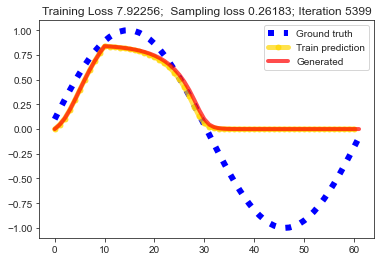

[5600] avg_loss: 8.18851, report_loss: 0.26184, 


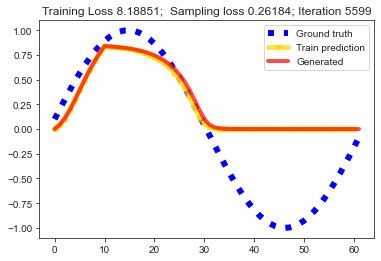

[5800] avg_loss: 8.45444, report_loss: 0.26183, 


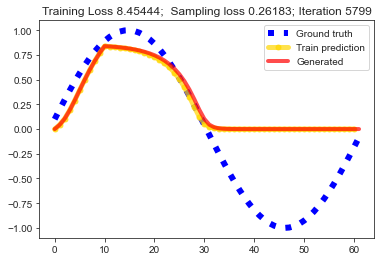

[6000] avg_loss: 8.72035, report_loss: 0.26169, 


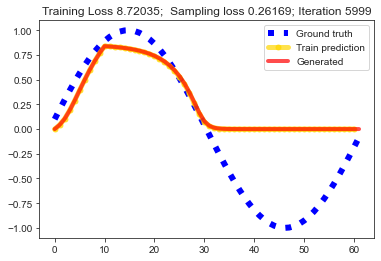

[6200] avg_loss: 8.98626, report_loss: 0.26170, 


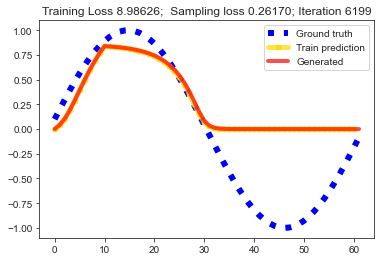

[6400] avg_loss: 9.25215, report_loss: 0.26167, 


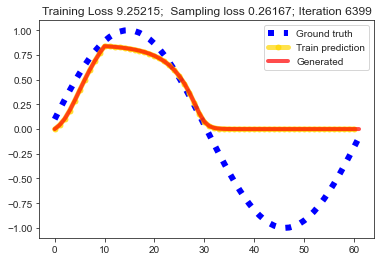

[6600] avg_loss: 9.51804, report_loss: 0.26181, 


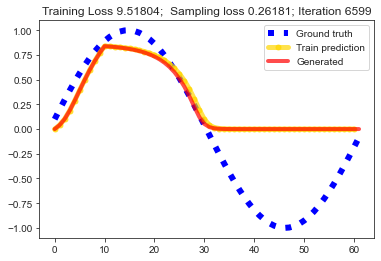

[6800] avg_loss: 9.78392, report_loss: 0.26176, 


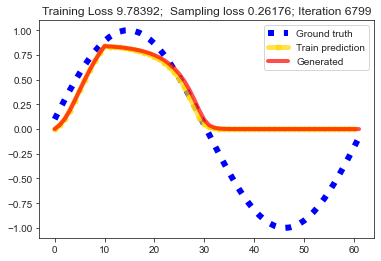

[7000] avg_loss: 10.04980, report_loss: 0.26171, 


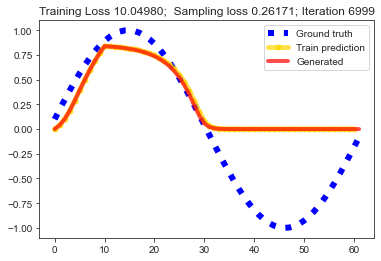

[7200] avg_loss: 10.31567, report_loss: 0.26165, 


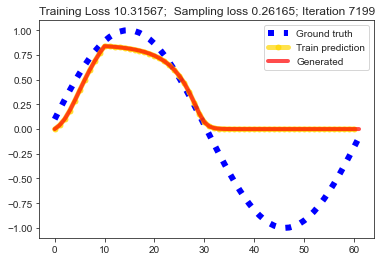

[7400] avg_loss: 10.58154, report_loss: 0.26169, 


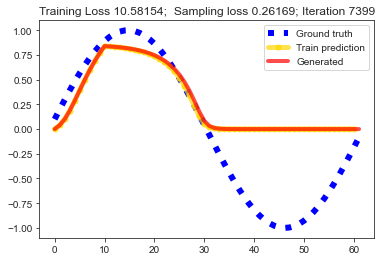

[7600] avg_loss: 10.84740, report_loss: 0.26166, 


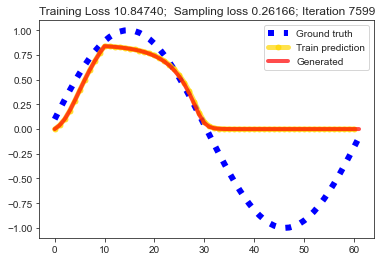

[7800] avg_loss: 11.11326, report_loss: 0.26165, 


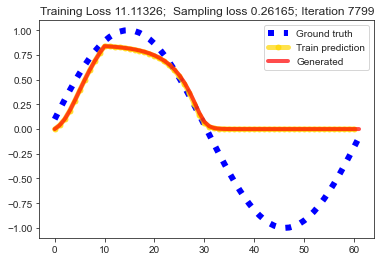

[8000] avg_loss: 11.37912, report_loss: 0.26167, 


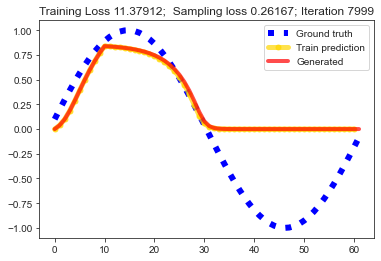

[8200] avg_loss: 11.64498, report_loss: 0.26167, 


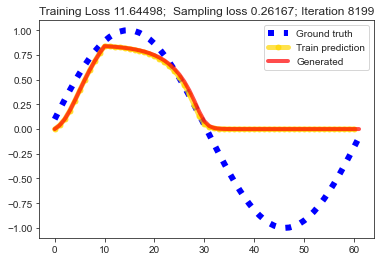

[8400] avg_loss: 11.91083, report_loss: 0.26167, 


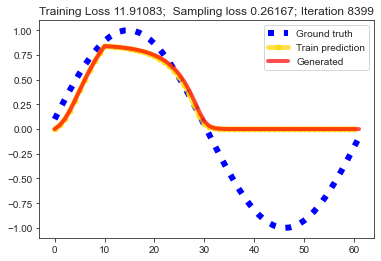

[8600] avg_loss: 12.17668, report_loss: 0.26167, 


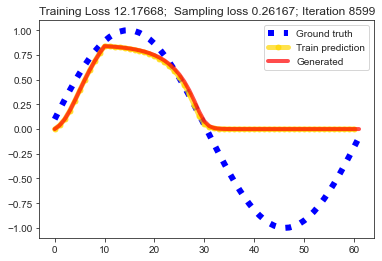

[8800] avg_loss: 12.44253, report_loss: 0.26167, 


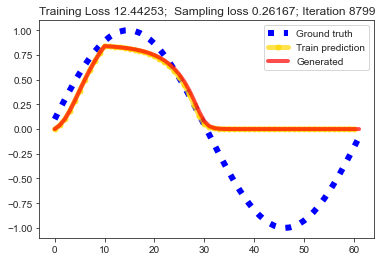

[9000] avg_loss: 12.70838, report_loss: 0.26167, 


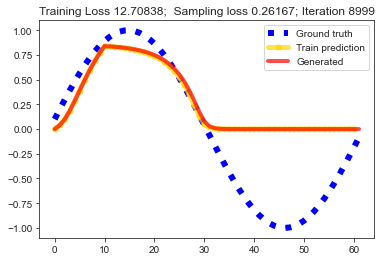

[9200] avg_loss: 12.97423, report_loss: 0.26167, 


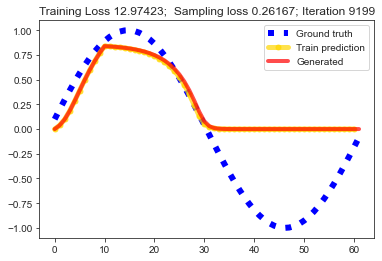

[9400] avg_loss: 13.24008, report_loss: 0.26166, 


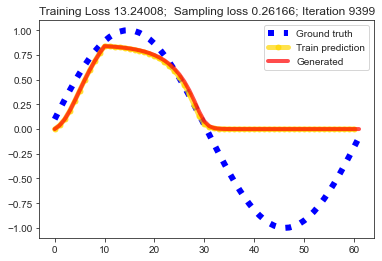

[9600] avg_loss: 13.50592, report_loss: 0.26166, 


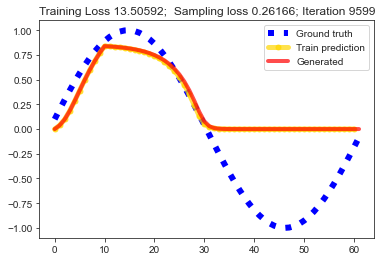

[9800] avg_loss: 13.77176, report_loss: 0.26166, 


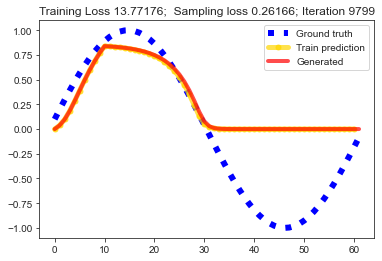

[10000] avg_loss: 14.03761, report_loss: 0.26166, 


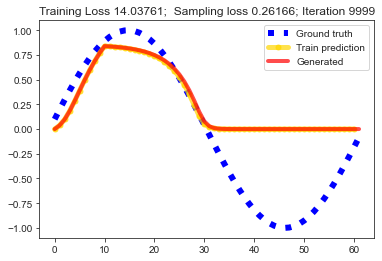

In [11]:
UNROLL_LENGTH = 62  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING = False  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.0001  #@param {type:"number"}
REPORTING_INTERVAL = 200  #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=False)
net.train()
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    start = np.random.choice(range(x_train.shape[0] - UNROLL_LENGTH))
    train_sequence = y_train[start : (start + UNROLL_LENGTH)]
    
    train_inputs = torch.from_numpy(train_sequence[:-1]).float().to(device)
    train_targets = torch.from_numpy(train_sequence[1:]).float().to(device)
    
    optimizer.zero_grad()
    
    outputs, hidden = net(train_inputs, hidden=None, force=TEACHER_FORCING, warm_start=WARM_START)
    loss = criterion(outputs, train_targets)
    loss.backward()
    
    running_loss += loss.item()
    
    optimizer.step()
    
    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        
        report_sequence = torch.from_numpy(y_train[:-1]).float().to(device)
        report_targets = torch.from_numpy(y_train[1:]).float().to(device)
        report_output, report_hidden = net(report_sequence, hidden=None, force=False, warm_start=WARM_START)
        
        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))
        
        plt.figure()
        plt.title('Training Loss %.5f;  Sampling loss %.5f; Iteration %d' % (avg_loss, report_loss.item(), iteration))
        
        plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
        plt.plot(range(start, start+UNROLL_LENGTH-1), outputs.data.numpy().ravel(), c='gold',
               label='Train prediction', lw=5, marker="o", markersize=5,
               alpha=0.7)
        plt.plot(report_output.data.numpy().ravel(), c='r', label='Generated', lw=4, alpha=0.7)
        plt.legend()
        plt.show()

[200] avg_loss: 0.51375, report_loss: 0.49800, 


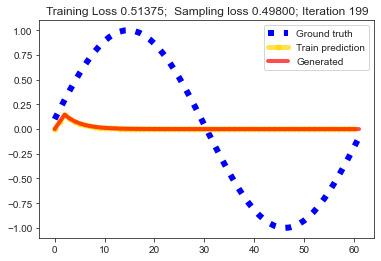

[400] avg_loss: 0.98486, report_loss: 0.46099, 


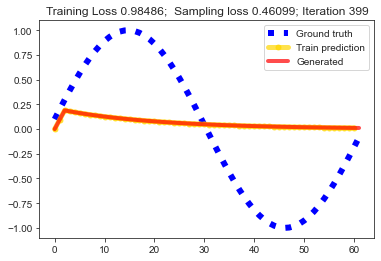

[600] avg_loss: 1.45325, report_loss: 0.46096, 


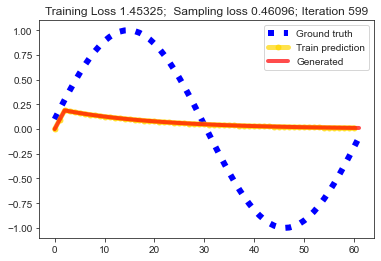

[800] avg_loss: 1.92161, report_loss: 0.46093, 


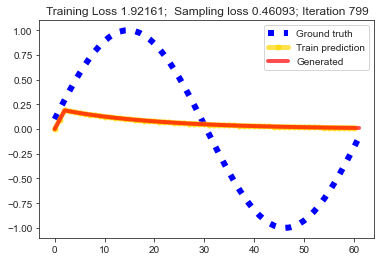

[1000] avg_loss: 2.38994, report_loss: 0.46090, 


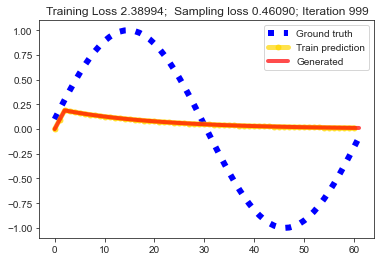

[1200] avg_loss: 2.85824, report_loss: 0.46087, 


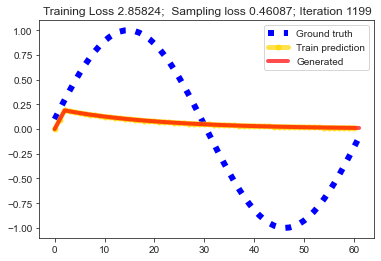

[1400] avg_loss: 3.32650, report_loss: 0.46083, 


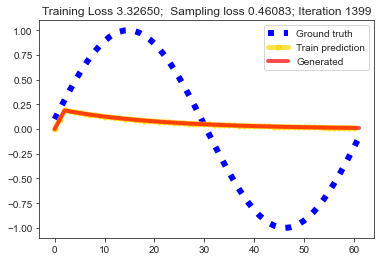

[1600] avg_loss: 3.79472, report_loss: 0.46080, 


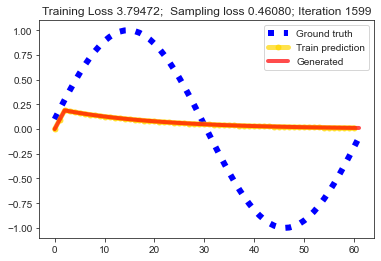

[1800] avg_loss: 4.26291, report_loss: 0.46076, 


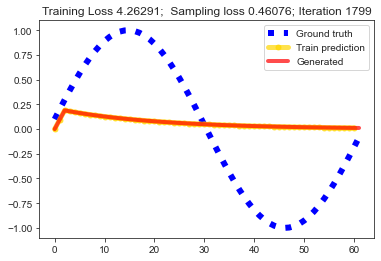

[2000] avg_loss: 4.73106, report_loss: 0.46072, 


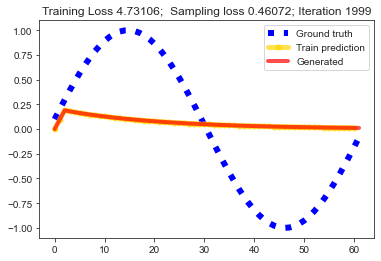

[2200] avg_loss: 5.19917, report_loss: 0.46068, 


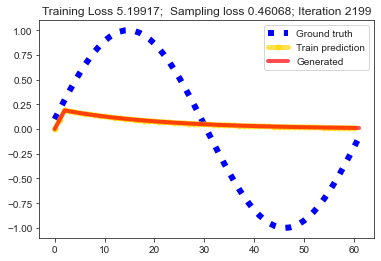

[2400] avg_loss: 5.66724, report_loss: 0.46065, 


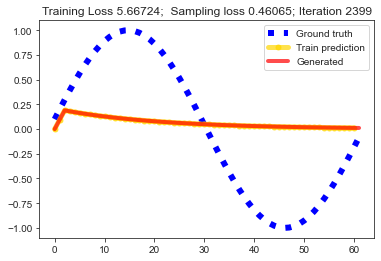

[2600] avg_loss: 6.13528, report_loss: 0.46061, 


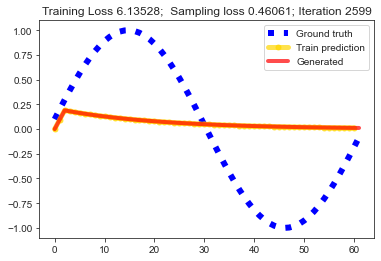

[2800] avg_loss: 6.60327, report_loss: 0.46057, 


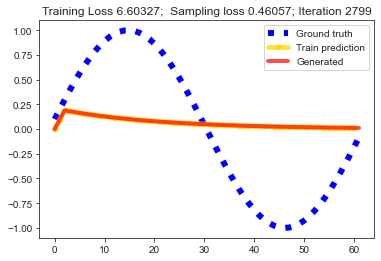

[3000] avg_loss: 7.07123, report_loss: 0.46054, 


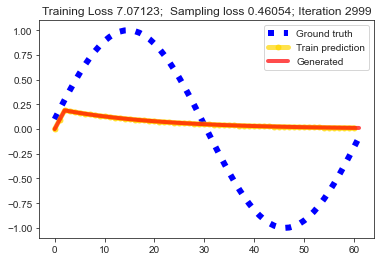

[3200] avg_loss: 7.53916, report_loss: 0.46050, 


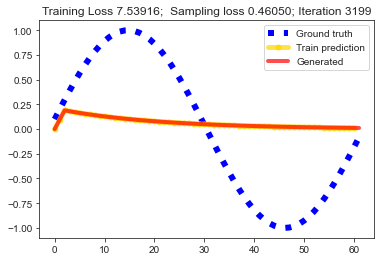

[3400] avg_loss: 8.00705, report_loss: 0.46047, 


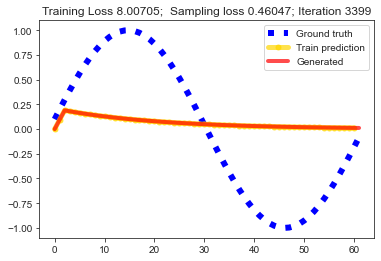

[3600] avg_loss: 8.47490, report_loss: 0.46044, 


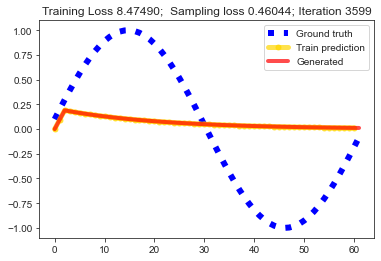

[3800] avg_loss: 8.94273, report_loss: 0.46041, 


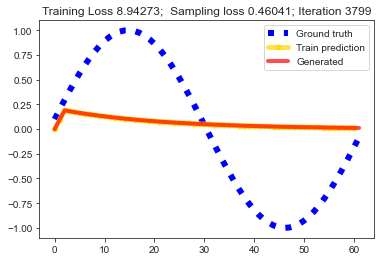

[4000] avg_loss: 9.41053, report_loss: 0.46038, 


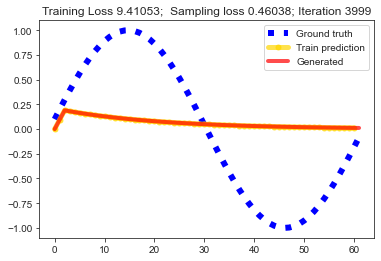

[4200] avg_loss: 9.87830, report_loss: 0.46036, 


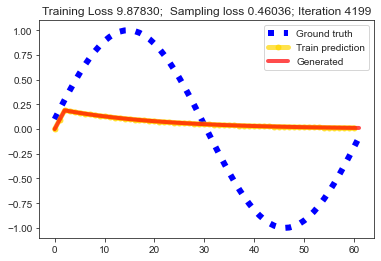

[4400] avg_loss: 10.34605, report_loss: 0.46034, 


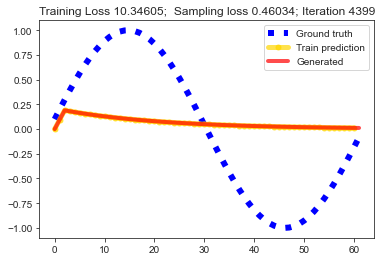

[4600] avg_loss: 10.81378, report_loss: 0.46032, 


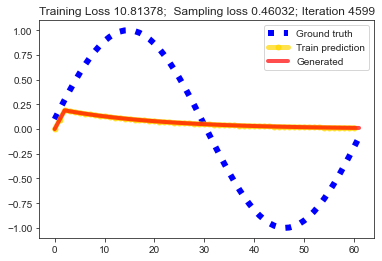

[4800] avg_loss: 11.28149, report_loss: 0.46030, 


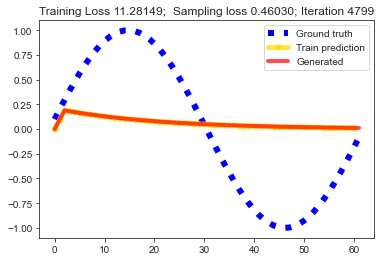

[5000] avg_loss: 11.74919, report_loss: 0.46029, 


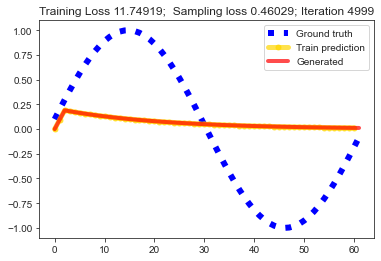

[5200] avg_loss: 12.21687, report_loss: 0.46028, 


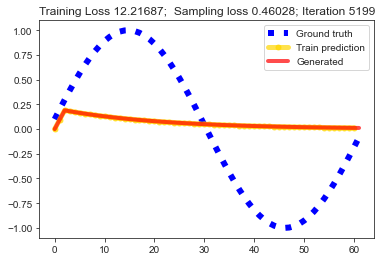

[5400] avg_loss: 12.68454, report_loss: 0.46026, 


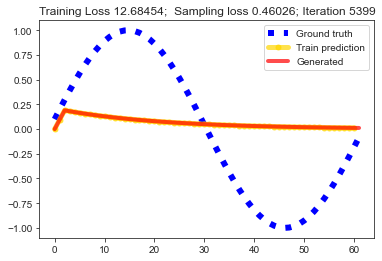

[5600] avg_loss: 13.15219, report_loss: 0.46025, 


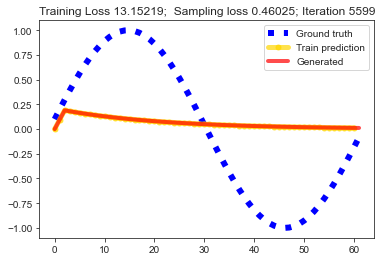

[5800] avg_loss: 13.61984, report_loss: 0.46024, 


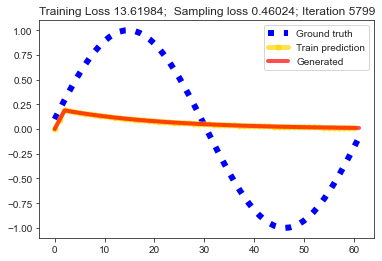

[6000] avg_loss: 14.08748, report_loss: 0.46024, 


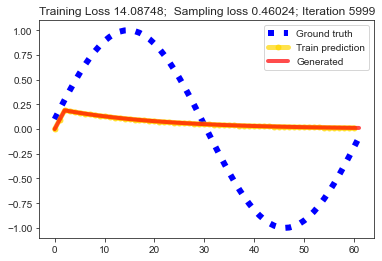

[6200] avg_loss: 14.55511, report_loss: 0.46023, 


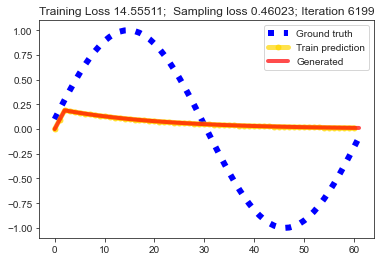

[6400] avg_loss: 15.02274, report_loss: 0.46023, 


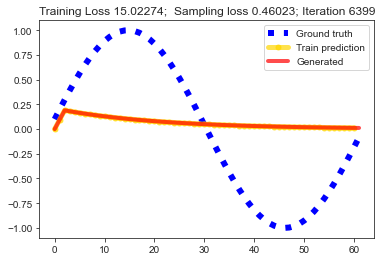

[6600] avg_loss: 15.49037, report_loss: 0.46022, 


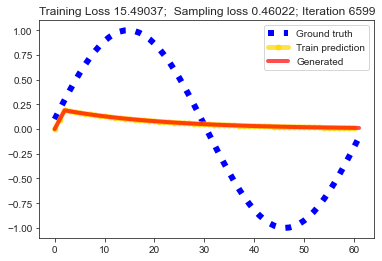

[6800] avg_loss: 15.95798, report_loss: 0.46022, 


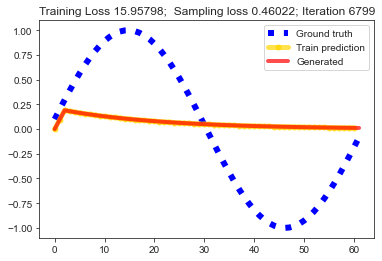

[7000] avg_loss: 16.42560, report_loss: 0.46021, 


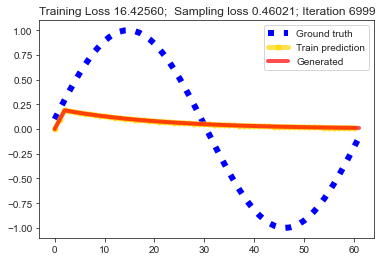

[7200] avg_loss: 16.89321, report_loss: 0.46021, 


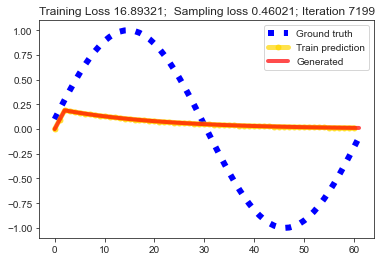

[7400] avg_loss: 17.36082, report_loss: 0.46021, 


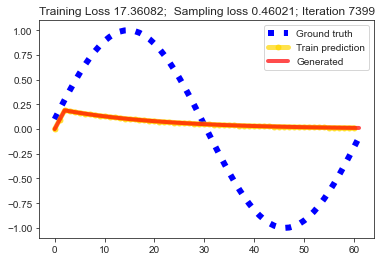

[7600] avg_loss: 17.82842, report_loss: 0.46020, 


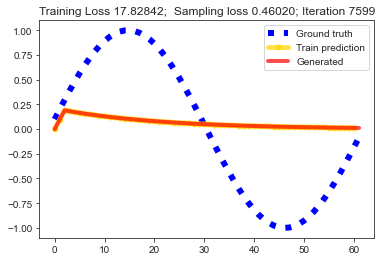

[7800] avg_loss: 18.29602, report_loss: 0.46020, 


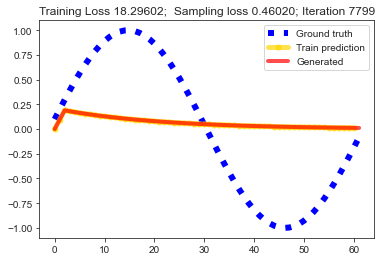

[8000] avg_loss: 18.76361, report_loss: 0.46020, 


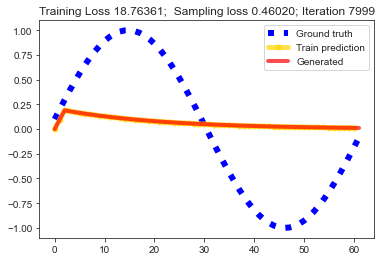

[8200] avg_loss: 19.23121, report_loss: 0.46019, 


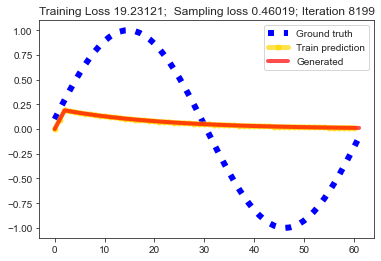

[8400] avg_loss: 19.69879, report_loss: 0.46019, 


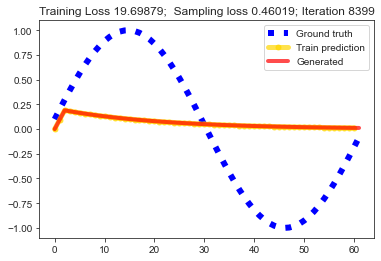

[8600] avg_loss: 20.16638, report_loss: 0.46019, 


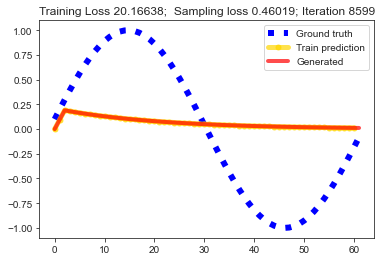

[8800] avg_loss: 20.63396, report_loss: 0.46018, 


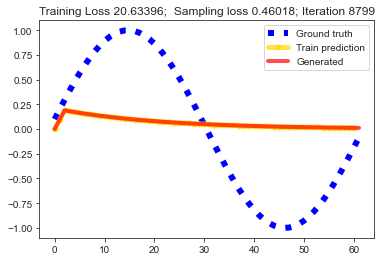

[9000] avg_loss: 21.10154, report_loss: 0.46018, 


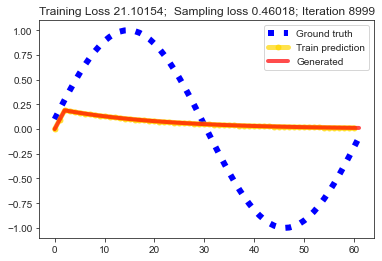

[9200] avg_loss: 21.56912, report_loss: 0.46018, 


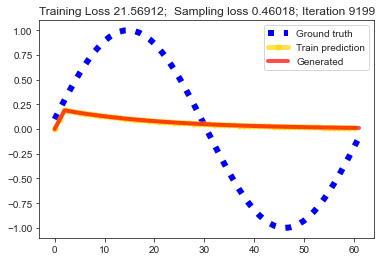

[9400] avg_loss: 22.03670, report_loss: 0.46018, 


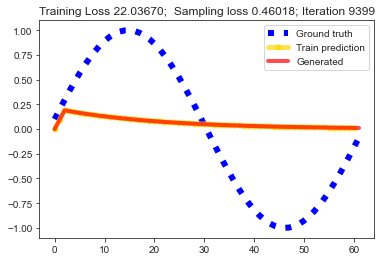

[9600] avg_loss: 22.50427, report_loss: 0.46018, 


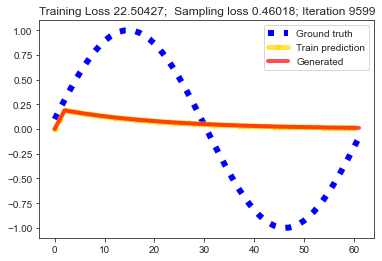

[9800] avg_loss: 22.97184, report_loss: 0.46017, 


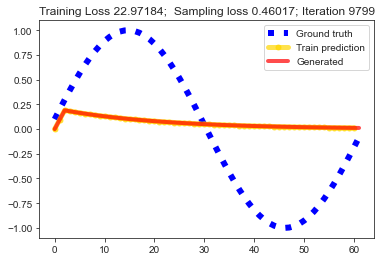

[10000] avg_loss: 23.43941, report_loss: 0.46017, 


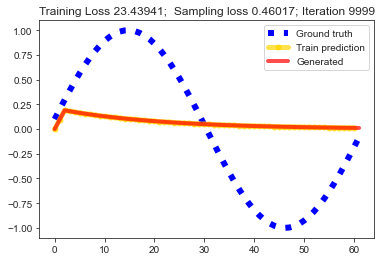

In [12]:
UNROLL_LENGTH = 62  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 2  #@param {type:"integer"}
TEACHER_FORCING = False  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.0001  #@param {type:"number"}
REPORTING_INTERVAL = 200  #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=False)
net.train()
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    start = np.random.choice(range(x_train.shape[0] - UNROLL_LENGTH))
    train_sequence = y_train[start : (start + UNROLL_LENGTH)]
    
    train_inputs = torch.from_numpy(train_sequence[:-1]).float().to(device)
    train_targets = torch.from_numpy(train_sequence[1:]).float().to(device)
    
    optimizer.zero_grad()
    
    outputs, hidden = net(train_inputs, hidden=None, force=TEACHER_FORCING, warm_start=WARM_START)
    loss = criterion(outputs, train_targets)
    loss.backward()
    
    running_loss += loss.item()
    
    optimizer.step()
    
    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        
        report_sequence = torch.from_numpy(y_train[:-1]).float().to(device)
        report_targets = torch.from_numpy(y_train[1:]).float().to(device)
        report_output, report_hidden = net(report_sequence, hidden=None, force=False, warm_start=WARM_START)
        
        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))
        
        plt.figure()
        plt.title('Training Loss %.5f;  Sampling loss %.5f; Iteration %d' % (avg_loss, report_loss.item(), iteration))
        
        plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
        plt.plot(range(start, start+UNROLL_LENGTH-1), outputs.data.numpy().ravel(), c='gold',
               label='Train prediction', lw=5, marker="o", markersize=5,
               alpha=0.7)
        plt.plot(report_output.data.numpy().ravel(), c='r', label='Generated', lw=4, alpha=0.7)
        plt.legend()
        plt.show()

### Default hypers:
##### UNROLL_LENGTH = 30  #@param {type:"integer"}
##### NUM_ITERATIONS = 10000  #@param {type:"integer"}
##### WARM_START = 2  #@param {type:"integer"}
##### TEACHER_FORCING = False  #@param {type:"boolean"}
##### HIDDEN_UNITS = 20  #@param {type:"integer"}
##### LEARNING_RATE = 0.0001  #@param {type:"number"}
##### REPORTING_INTERVAL = 2000  #@param {type:"integer"}

#### You may want to try:
#### default hypers with/without teacher forcing
#### use UNROLL_LENGTH = 62 to train on the whole sequence (is teacher forcing useful?)
> Response: Is usefull in the sense that the model can achieve converge faster, but the results have a very bad quality.
#### use UNROLL_LENGTH = 62, no teacher forcing and warm_start = 2 # this should break training
> The worst results due to the small warm start. We have the opposite, which is cold start and the model does not have a good example to start from

**Note:** initialization is not fixed (we do not fix a random seed), so each time the cell is executed, the parameters take new initial values and hence training can lead to different results. What happens if you run it multiple times?

> Response: The results will be completly impredictible due to the non fixed random seed, especially due to weights initialisation which is default done by PyTorch. In this sense I have fixed a random seed at the begining of the notebook to ensure reproductible resuls.

###What is worth trying/understanding here?

* Difference between teacher forcing and learning on own samples:
 * What are the pros and cons of teacher forcing?
 > Pros: Training with Teacher Forcing converges faster, in our case if we take a closer look at the average loss, for teacher forcing is much smaller from a lower starting point. At the early stages of training, the predictions of the model are very bad.
 
 > Cons: During inference, since there is usually no ground truth available, the RNN model will need to feed its own previous prediction back to itself for the next prediction. Therefore there is a discrepancy between training and inference, and this might lead to poor model performance and instability. This is known as **Exposure Bias** in literature.
 
 * Why is the model struggling to learn in one of the setups?
 > If we do not use Teacher Forcing, the hidden states of the model will be updated by a sequence of wrong predictions, errors will accumulate, and it is difficult for the model to learn from that. Is important to mention that at least **in my case** the generated samples are very bad when trained on ground truth, so teacher forcing is not very useful, especially considering the quality of dataset.
 * What is it we actually care about for models like this? What should be the actual surrogate?
 > Response: I can say that the learning task is more important in this case that the results itself.
* How does warm starting affect our training? Why?
> Response: Worm start is heavily affecting the model due to the fact that the network is keeping incresing its independency, and it is learning from the actual predictions. The opposite is the cold start where we have the problem of identity function: $f: R -> R$ where $f(x) = x$ so the model will mimic the reality and not learn from it.
* What happens if the structure of interest is much longer than the unroll length?
> Response: we will suffer from a deficiency of information. The length is used for information gain and there is a direct relation between how much the nn will learn and how many information we give it access to.

#### Bibliography

- [A simple description of teacher forcing](https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c) 

## Conclusion: at leat for this experiment warm start 10 and unroll length in full, w/o teacher forcing will give the best quality results.